#### Loading Libraries

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from itertools import product
import time

#Tests for sample comparison
from scipy.stats import spearmanr
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from statsmodels.stats.diagnostic import lilliefors

#ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima


#Prophet
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#LightGBM
import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping, log_evaluation

#XGBoost
import xgboost as xgb
from xgboost import plot_importance

#Libraries for tuning NHITS and envieroment setup
import logging
from ray import tune
from IPython.display import display

#NHITS
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MAE,RMSE,MQLoss

from utilsforecast.plotting import plot_series
from utilsforecast.losses import mse, mae, rmse
from utilsforecast.evaluation import evaluate

#Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,ParameterGrid 
from sklearn.preprocessing import LabelEncoder,StandardScaler

#Model extension
import shap

#### Loading Data

In [56]:
train_set = pd.read_csv(r"C:\Users\Armando\Desktop\data\train.csv")
stores_set = pd.read_csv(r"C:\Users\Armando\Desktop\data\stores.csv")
oil_set = pd.read_csv(r"C:\Users\Armando\Desktop\data\oil.csv")
holiday_set = pd.read_csv(r"C:\Users\Armando\Desktop\data\holidays_events.csv")
transactions_set = pd.read_csv(r"C:\Users\Armando\Desktop\data\transactions.csv")
test_set = pd.read_csv(r"C:\Users\Armando\Desktop\data\test.csv")

#### Display Options

In [57]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
#αν θελω reset
#pd.reset_option('display.max_columns')

#### Data Preparation

In [58]:
#ελεγχος για διπλοτυπα
print(train_set.duplicated().sum(),
      stores_set.duplicated().sum(),
      oil_set.duplicated().sum(),
      holiday_set.duplicated().sum(),
      transactions_set.duplicated().sum(),
      test_set.duplicated().sum()
      )

0 0 0 0 0 0


In [59]:
train_set.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [60]:
stores_set.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [61]:
oil_set.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [62]:
holiday_set.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [63]:
holiday_set.locale.unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [64]:
transactions_set.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [65]:
test_set.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [66]:
#Merges
df = pd.merge(train_set,stores_set,on='store_nbr',how='left')
df = pd.merge(df,oil_set,on ='date',how='left')
df = pd.merge(df,transactions_set,on=['date','store_nbr'],how='left')

In [67]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN


In [68]:
print(
    f"The dataset contains {df.shape[0]} samples and "
    f"{df.shape[1]} features"
)

The dataset contains 3000888 samples and 12 features


In [69]:
#Κοιταω για Nas
df.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type                 0
cluster              0
dcoilwtico      928422
transactions    245784
dtype: int64

In [70]:
sales_zero = df[df['sales'] == 0]

In [71]:
sales_zero.isna().sum() # 291028 - 245869 = 45159

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type                 0
cluster              0
dcoilwtico      291028
transactions    242536
dtype: int64

In [72]:
df.loc[df['sales']==0,'transactions']=0
del sales_zero
df['transactions'] = df.groupby('store_nbr')['transactions'].ffill()

In [73]:
#Απο αυτο βλεπουμε οτι δεν εχουμε την τιμη του πετρελαιου για ολες τις ημερομινιες
print(len(train_set['date'].unique()),len(oil_set['date'].unique()))

1684 1218


In [74]:
df['date']= pd.to_datetime(df['date'])
df['day']= df['date'].dt.day_name()
working_days = df[df['date'].dt.dayofweek < 5]

In [75]:
print(df.loc[df['day'] == 'Saturday', 'dcoilwtico'].isna().sum() +
      df.loc[df['day'] == 'Sunday', 'dcoilwtico'].isna().sum() 
      )

857142


In [76]:
#Βρισκω το Σ/Κ με τιμες Na στο πετρελαιο
weekend_mask = df['day'].isin(['Saturday', 'Sunday']) & df['dcoilwtico'].isna()
df['price_filled'] = df['dcoilwtico']
df['price_filled'] = df['price_filled'].where(df['day'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']))
df['price_filled'] = df['price_filled'].ffill()
df.loc[weekend_mask, 'dcoilwtico'] = df.loc[weekend_mask, 'price_filled']
df.drop(columns=['price_filled'], inplace=True)

In [77]:
df['dcoilwtico'] = df['dcoilwtico'].interpolate(method='linear')
df['dcoilwtico'] = df['dcoilwtico'].bfill()
df['transactions'] = df['transactions'].fillna(0)

In [78]:
#Για τις υπολοιπες τιμες του πετρελαιου που δεν εχουμε κανουμε imputation
#df['dcoilwtico'] = df['dcoilwtico'].ffill()

In [79]:
holiday_set.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  transactions  float64       
 12  day           object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 297.6+ MB


In [81]:
transactions_set.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [82]:
df.isna().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
type            0
cluster         0
dcoilwtico      0
transactions    0
day             0
dtype: int64

In [83]:
df.isna().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
type            0
cluster         0
dcoilwtico      0
transactions    0
day             0
dtype: int64

In [84]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday


#### Exploratory Data Analysis

In [85]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Tuesday


In [86]:
print(
    f"The dataset contains {df.shape[0]} samples and "
    f"{df.shape[1]} features"
)

The dataset contains 3000888 samples and 13 features


In [87]:
len(df['store_nbr'].unique())

54

In [88]:
df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [89]:
len(df['family'].unique())

33

In [90]:
df['city'].unique()

array(['Quito', 'Cayambe', 'Latacunga', 'Riobamba', 'Ibarra',
       'Santo Domingo', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil',
       'Salinas', 'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad',
       'Cuenca', 'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [91]:
len(df['city'].unique())

22

In [92]:
df['state'].unique()

array(['Pichincha', 'Cotopaxi', 'Chimborazo', 'Imbabura',
       'Santo Domingo de los Tsachilas', 'Bolivar', 'Pastaza',
       'Tungurahua', 'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja',
       'El Oro', 'Esmeraldas', 'Manabi'], dtype=object)

In [93]:
len(df['state'].unique())

16

In [94]:
df['type'].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

In [95]:
df['cluster'].unique()

array([13, 15,  6,  7,  3, 12, 16,  9,  1, 10,  8,  2,  4,  5, 11, 14, 17],
      dtype=int64)

In [96]:
df['day'].unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

In [97]:
df[['sales','onpromotion','transactions','dcoilwtico']].describe()

,sales,onpromotion,transactions,dcoilwtico
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,3.577757e+02,2.602770e+00,1.196714e+03,6.791966e+01
std,1.101998e+03,1.221888e+01,1.148411e+03,2.567090e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,2.619000e+01
25%,0.000000e+00,0.000000e+00,0.000000e+00,4.637750e+01
50%,1.100000e+01,0.000000e+00,1.113000e+03,5.341000e+01
75%,1.958473e+02,0.000000e+00,1.749000e+03,9.572000e+01
max,1.247170e+05,7.410000e+02,8.359000e+03,1.106200e+02


In [98]:
#Εδω δημιουργω ενα γραφημα για τα sales σε βαθος χρονου
#Για να γινει αυτο θα πρεπει να αθροισω τα sales καθε μερας καθως το υπαρχον dataset εχει 
#sales για ολες τις ημερες 
daily_sales = df[['date','sales']].copy()
daily_sales = daily_sales.groupby('date').sum().reset_index()


In [99]:
px.line(daily_sales,x='date',y='sales',title="Daily Sales")

In [100]:
#Εδω ενονω τις τιμες του πετρελαιου με τα daily sales για να κανω correlation test
daily_oil = df[['date', 'dcoilwtico']].dropna().drop_duplicates(subset='date')
daily_df = pd.merge(daily_sales,daily_oil,on='date',how='left')
daily_df.head()

,date,sales,dcoilwtico
0,2013-01-01,2511.618999,93.14
1,2013-01-02,496092.417944,93.14
2,2013-01-03,361461.231124,92.97
3,2013-01-04,354459.677093,93.12
4,2013-01-05,477350.121229,93.12


In [101]:
moving_average = daily_df['sales'].rolling(
    window = len(daily_df['sales']),
    center = True,
    min_periods = len(daily_df['sales'])//2,
).mean()

daily_df['moving_average'] = moving_average

In [102]:
fig1 = px.scatter(daily_df, x='date', y='sales')
fig2 = px.line(daily_df, x='date', y='moving_average', color_discrete_sequence=['red'])
fig3 = go.Figure(data=fig1.data + fig2.data)
fig3 = fig3.update_layout(xaxis_title="Sales", yaxis_title="Date", title = 'Moving Average Over Time')
fig3.show()

In [103]:
df['year'] = df['date'].dt.year
avg_sales_year_family = df.groupby(['year', 'family'])['sales'].mean().reset_index()

In [104]:

fig = px.line(
    avg_sales_year_family,
    x='year',
    y='sales',
    color='family',
    facet_col='family',
    facet_col_wrap= 4,
    markers=True,
    title='Average Yearly Sales per Product Family'
)
fig.update_yaxes(matches=None)
fig.update_layout(height=2000,showlegend=False)
fig.show()
# fig.update_layout(
#     xaxis_title='Year',
#     yaxis_title='Average Sales',
#     legend_title='Family',
#     width=1000,
#     height=600
# )

fig.show()


In [105]:
# families = avg_sales_year_family['family'].unique()
# for family in families:
#     df_family = avg_sales_year_family[avg_sales_year_family['family'] == family]
    
#     fig = px.line(
#         df_family,
#         x='year',
#         y='sales',
#         markers=True,
#         title=f'Average Yearly Sales for Product Family: {family}'
#     )
    
#     fig.update_layout(
#         showlegend=False,
#         height=500,
#         xaxis_title='Year',
#         yaxis_title='Sales'
#     )
    
#     fig.show()
#     time.sleep(5)  # Καθυστέρηση 5 δευτερολέπτων

In [106]:
import time

In [107]:
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.strftime('%B')
avg_sales_by_month = df.groupby(['month', 'month_name', 'family'])['sales'].mean().reset_index()

avg_sales_by_month = avg_sales_by_month.sort_values('month')

In [108]:
fig = px.line(
    avg_sales_by_month,
    x='month_name',
    y='sales',
    color='family',
    facet_col='family',
    facet_col_spacing=0.1,
    facet_col_wrap=4,
    markers=True,
    category_orders={"month_name": [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]},
    title='Average Sales by Calendar Month per Product Family'
)
fig.update_yaxes(matches=None)
fig.update_layout(height=2000,showlegend=False)

# fig.update_layout(
#     xaxis_title='Month',
#     yaxis_title='Average Sales',
#     legend_title='Family',
#     width=1000,
#     height=600
# )

fig.show()


In [109]:
df['day_nbr'] = df['date'].dt.weekday
avg_sales_by_weekday = df.groupby(['day_nbr', 'day', 'family'])['sales'].mean().reset_index()

In [110]:
avg_sales_by_weekday = avg_sales_by_weekday.sort_values('day_nbr')
fig = px.line(
    avg_sales_by_weekday,
    x='day',
    y='sales',
    color='family',
    facet_col='family',
    facet_col_wrap=4,
    markers=True,
    category_orders={"day": [
        "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
    ]},
    title='Average Sales by Day of Week per Product Family'
)

fig.update_yaxes(matches=None)
fig.update_layout(height=2000,showlegend=False)

# fig.update_layout(
#     xaxis_title='Day of Week',
#     yaxis_title='Average Sales',
#     legend_title='Family',
#     width=1000,
#     height=600
# )

fig.show()


In [111]:
t = df.groupby("family")['sales'].mean().sort_values(ascending=False).reset_index()
px.bar(t,y='family',x='sales',color='family',title='Average sales per product family')

In [112]:
t = df.groupby("city")['sales'].mean().sort_values(ascending=False).reset_index()
px.bar(t,y='city',x='sales',color='city',title='Average sales per City')

In [113]:
# temp = df[["store_nbr", "sales"]].copy()
# temp["ind"] = 1
# temp["ind"] = temp.groupby("store_nbr")["ind"].cumsum().values
# pivot_sales = pd.pivot(temp, index="ind", columns="store_nbr", values="sales")

# corr_matrix = pivot_sales.corr()
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# plt.figure(figsize=(20, 20))
# sns.heatmap(corr_matrix,
#             annot=True,
#             fmt='.1f',
#             cmap='coolwarm',
#             square=True,
#             mask=mask,
#             linewidths=1,
#             cbar=False)
# plt.title("Correlations among stores", fontsize=20)
# plt.show()

#### Oil Price - Impact on Sales

In [114]:
#Αυτο εχει και αλλη δουλεια
px.line(daily_oil,x='date',y='dcoilwtico')

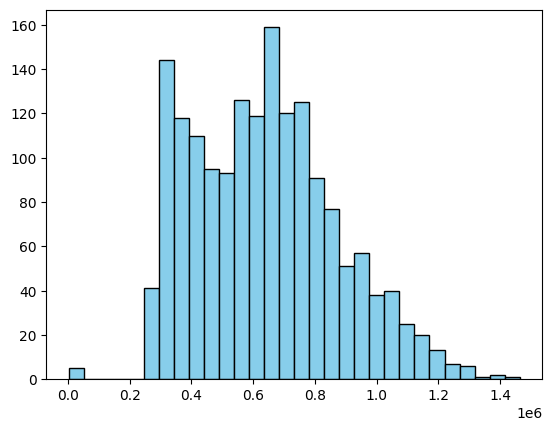

In [115]:
plt.hist(daily_df['sales'],bins=30, color='skyblue', edgecolor='black');

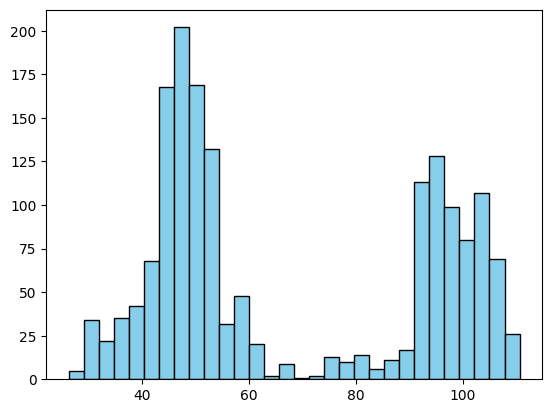

In [116]:
plt.hist(daily_df['dcoilwtico'],bins=30, color='skyblue', edgecolor='black');

In [117]:
corr, p_value = spearmanr(daily_df['sales'], daily_df['dcoilwtico'])

print(f"Spearman correlation: {corr}")
print(f"P-value: {p_value}")

Spearman correlation: -0.6082715617552258
P-value: 5.664189454391659e-171


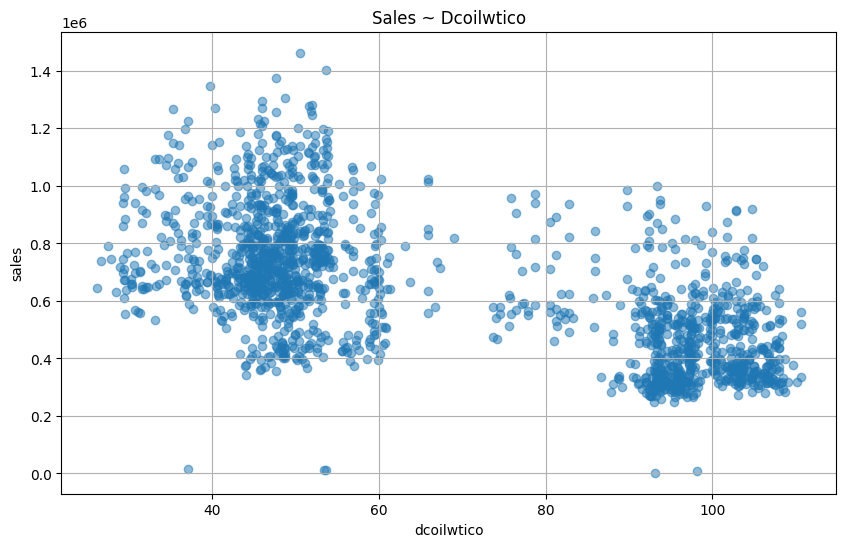

In [118]:
plt.figure(figsize=(10, 6))
plt.scatter(daily_df['dcoilwtico'], daily_df['sales'], alpha=0.5)
plt.title('Sales ~ Dcoilwtico')
plt.xlabel('dcoilwtico')
plt.ylabel('sales')
plt.grid(True)
plt.show()


#### OnPromotion - Impact on Sales

In [119]:
corr, p_value = spearmanr(df['sales'], df['onpromotion'])

print(f"Spearman correlation: {corr}")
print(f"P-value: {p_value}")


Spearman correlation: 0.5380218163559255
P-value: 0.0


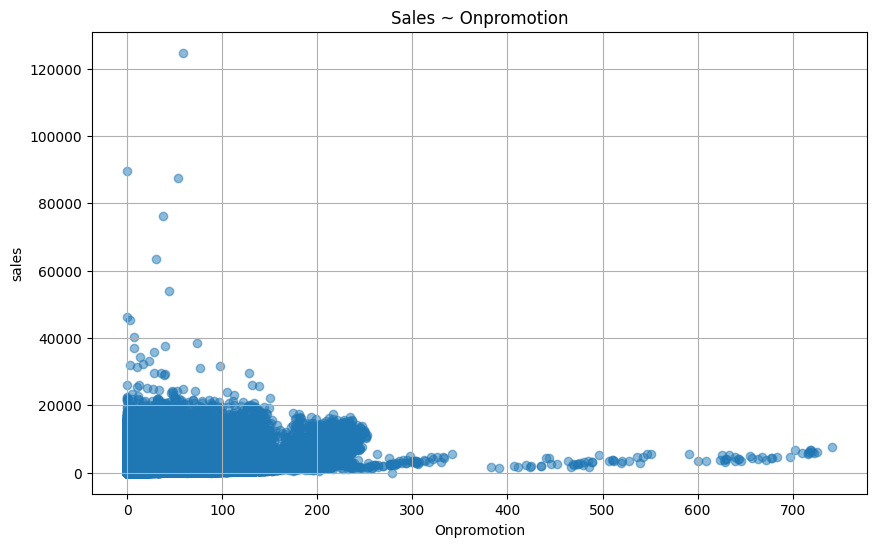

In [120]:
plt.figure(figsize=(10, 6))
plt.scatter(df['onpromotion'],df['sales'], alpha=0.5)
plt.title('Sales ~ Onpromotion')
plt.xlabel('Onpromotion')
plt.ylabel('sales')
plt.grid(True)
plt.show()

#### Earthquake - Impact on Sales

In [121]:
daily_df["date"] = pd.to_datetime(daily_df["date"])
before = daily_df[(daily_df["date"] >= '2016-03-01') & (daily_df["date"] <= '2016-04-15')]
after = daily_df[(daily_df["date"] >= '2016-04-16') & (daily_df["date"] <= '2016-05-31')]

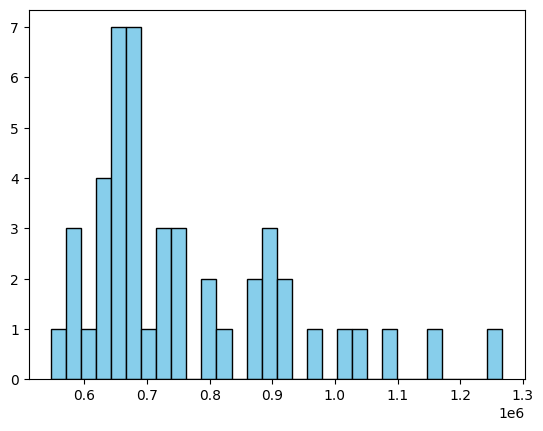

In [122]:
plt.hist(before['sales'], bins=30, color='skyblue', edgecolor='black');


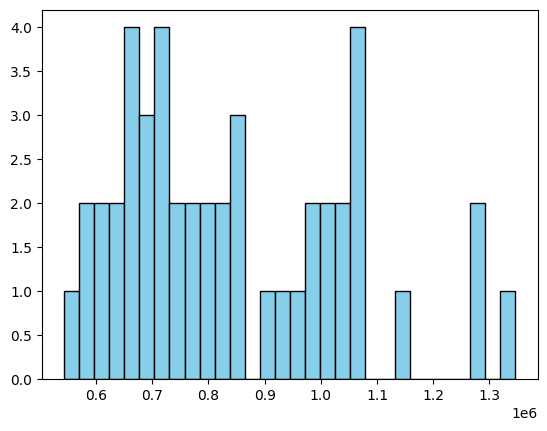

In [123]:
plt.hist(after['sales'], bins=30, color='skyblue', edgecolor='black');


In [124]:
stat, p_value = mannwhitneyu(before['sales'], after['sales'])

print(f"U statistic: {stat}")
print(f"P-value: {p_value}")

U statistic: 785.0
P-value: 0.03334269022409122


In [125]:
before[['sales']].describe()

,sales
count,4.600000e+01
mean,7.631802e+05
std,1.625897e+05
min,5.467852e+05
25%,6.606319e+05
50%,6.925578e+05
75%,8.769561e+05
max,1.266908e+06


In [126]:
after[['sales']].describe()

,sales
count,4.600000e+01
mean,8.427815e+05
std,2.017883e+05
min,5.433398e+05
25%,6.832532e+05
50%,7.954300e+05
75%,9.943918e+05
max,1.345921e+06


In [127]:
df[['sales']].describe()

,sales
count,3.000888e+06
mean,3.577757e+02
std,1.101998e+03
min,0.000000e+00
25%,0.000000e+00
50%,1.100000e+01
75%,1.958473e+02
max,1.247170e+05


In [128]:
del avg_sales_by_month,avg_sales_by_weekday,avg_sales_year_family,moving_average,daily_df,daily_oil,daily_sales
del train_set,oil_set,transactions_set,before,after,weekend_mask
del fig,fig1,fig2,fig3,working_days,

In [129]:
df.shape

(3000888, 17)

In [130]:
holiday_set['date'] = pd.to_datetime(holiday_set['date'])
holiday_set[holiday_set['transferred']==True]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


In [131]:
#Το προβλημα με τα transfers
temp1 = holiday_set[(holiday_set['type']=='Holiday')& (holiday_set['transferred']==True)].drop('transferred',axis=1).reset_index(drop=True)
temp2 = holiday_set[(holiday_set['type']=='Transfer')].drop('transferred',axis=1).reset_index(drop=True)
temp = pd.concat([temp1,temp2],axis=1)
temp = temp.iloc[:,[5,1,2,3,4,]]
holiday_set = holiday_set[(holiday_set['type']!='Transfer')& (holiday_set['transferred']==False)].drop('transferred',axis=1)
holiday_set = pd.concat([holiday_set, temp]).reset_index(drop=True)
del temp,temp1,temp2

In [132]:
#Κραταω αυτο για το Prophet μετα
holidays_for_prophet = holiday_set.copy()
holidays_for_prophet= holidays_for_prophet.drop(['type','locale_name','locale'],axis=1)

In [133]:
holiday_set['type']= np.where(holiday_set['type']=='Additional','Holiday',holiday_set['type'])
holiday_set['type']= np.where(holiday_set['type']=='Bridge','Holiday',holiday_set['type'])

In [134]:
work_days_left = holiday_set[holiday_set.type=='Work Day']
holiday_set = holiday_set[holiday_set.type!='Work Day']

In [135]:
events = holiday_set[holiday_set.type=='Event'].drop(['type','locale','locale_name'],axis=1)
events= events.rename({"description":"event"},axis=1)
holiday_set = holiday_set[holiday_set.type!='Event'].drop("type",axis=1)

In [136]:
regional = holiday_set[holiday_set['locale']=='Regional'].rename({"locale_name":"state","description":"holiday_regional"},axis=1).drop("locale",axis=1).drop_duplicates()
national = holiday_set[holiday_set['locale']=='National'].rename({"description":"holiday_national"},axis=1).drop(["locale","locale_name"],axis=1).drop_duplicates()
local = holiday_set[holiday_set['locale']=='Local'].rename({"locale_name":"city","description":"holiday_local"},axis=1).drop("locale",axis=1).drop_duplicates()

In [137]:
events['date'] = pd.to_datetime(events['date'])
national['date'] = pd.to_datetime(national['date'])
regional['date'] = pd.to_datetime(regional['date'])

In [138]:
print(events[events['date'].duplicated()])


          date            event
239 2016-05-08  Dia de la Madre


In [139]:
print(national[national['date'].duplicated()])


          date      holiday_national
34  2012-12-24             Navidad-1
38  2012-12-31  Primer dia del ano-1
151 2014-12-26             Navidad+1


In [140]:
print(local[local['date'].duplicated()])


          date           city               holiday_local
9   2012-06-25        Machala        Fundacion de Machala
11  2012-07-03      El Carmen  Cantonizacion de El Carmen
58  2013-06-25      Latacunga  Cantonizacion de Latacunga
60  2013-07-03  Santo Domingo  Fundacion de Santo Domingo
107 2014-06-25        Machala        Fundacion de Machala
115 2014-07-03  Santo Domingo  Fundacion de Santo Domingo
172 2015-06-25      Latacunga  Cantonizacion de Latacunga
174 2015-07-03  Santo Domingo  Fundacion de Santo Domingo
252 2016-06-25      Latacunga  Cantonizacion de Latacunga
254 2016-07-03  Santo Domingo  Fundacion de Santo Domingo
299 2017-06-25        Machala        Fundacion de Machala
301 2017-07-03  Santo Domingo  Fundacion de Santo Domingo
330 2016-07-24      Guayaquil      Fundacion de Guayaquil
337 2017-12-08          Quito          Fundacion de Quito


In [141]:
# Check for duplicate keys in the lookup tables
print(national['date'].duplicated().sum())         
print(regional.duplicated(['date', 'state']).sum()) 
print(local.duplicated(['date', 'city']).sum())     
print(events['date'].duplicated().sum())           


3
0
1
1


In [142]:
events = events.drop_duplicates(subset=['date'])
national= national.drop_duplicates(subset=['date'])
local= local.drop_duplicates(subset=['date','city'])

In [143]:
events['date'] = pd.to_datetime(events['date'])
national['date'] = pd.to_datetime(national['date'])
regional['date'] = pd.to_datetime(regional['date'])
df = pd.merge(df,national,how='left',on='date')
df = pd.merge(df,regional,how='left',on=['date',"state"])
df = pd.merge(df,local,how='left',on=['date',"city"])
df = pd.merge(df,events,on=['date'],how='left')


In [144]:
test_set['date'] = pd.to_datetime(test_set['date'])
test_df = pd.merge(test_set,stores_set,on='store_nbr',how='left')
test_df = pd.merge(test_df,national,how='left',on='date')
test_df = pd.merge(test_df,regional,how='left',on=['date',"state"])
test_df = pd.merge(test_df,local,how='left',on=['date',"city"])
test_df = pd.merge(test_df,events,on=['date'],how='left')

In [145]:
# Make sure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Generate complete date range from min to max
full_range = pd.date_range(start=df['date'].min(), end=df['date'].max())

# Get unique dates from your data
present_dates = df['date'].drop_duplicates()

# Find missing dates
missing_dates = full_range.difference(present_dates)

# Output missing dates
print("Missing dates:")
print(missing_dates)

Missing dates:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [146]:
missing_df = pd.DataFrame({'date': missing_dates})
store_family_combos = df[['store_nbr', 'family', 'city', 'state', 'cluster','type']].drop_duplicates()
missing_df = pd.DataFrame([(d, *row) for d in missing_dates for row in store_family_combos.itertuples(index=False)],
                          columns=['date', 'store_nbr', 'family', 'city', 'state', 'cluster','type'])
missing_df['id'] = range(3000888, 3000888 + len(missing_df))
missing_df['sales'] = 0
missing_df['onpromotion'] = 0
missing_df['transactions'] = 0
missing_df['day'] = missing_df['date'].dt.day
missing_df['month'] = missing_df['date'].dt.month
missing_df['year'] = missing_df['date'].dt.year
missing_df['month_name'] = missing_df['date'].dt.month_name()
missing_df['day_nbr'] = missing_df['date'].dt.weekday
missing_df['holiday_national'] = 'no_holiday'
missing_df['holiday_regional'] = 'no_holiday'
missing_df['holiday_local'] = 'no_holiday'
missing_df['event'] = 'Christmas'

In [147]:
dates = ['2013-12-24', '2014-12-24', '2015-12-24', '2016-12-24']
df[df['date'].isin(pd.to_datetime(dates))].drop_duplicates(subset=['date'])

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,day,year,month,month_name,day_nbr,holiday_national,holiday_regional,holiday_local,event
636174,636174,2013-12-24,1,AUTOMOTIVE,1.0,0,Quito,Pichincha,D,13,98.87,2844.0,Tuesday,2013,12,December,1,Navidad-1,NaN,NaN,NaN
1284822,1284822,2014-12-24,1,AUTOMOTIVE,6.0,0,Quito,Pichincha,D,13,55.70,2800.0,Wednesday,2014,12,December,2,Navidad-1,NaN,NaN,NaN
1933470,1933470,2015-12-24,1,AUTOMOTIVE,4.0,0,Quito,Pichincha,D,13,37.62,2775.0,Thursday,2015,12,December,3,Navidad-1,NaN,NaN,NaN
2583900,2583900,2016-12-24,1,AUTOMOTIVE,6.0,0,Quito,Pichincha,D,13,52.01,1993.0,Saturday,2016,12,December,5,Navidad-1,NaN,NaN,NaN


In [148]:
missing_df['dcoilwtico'] = 0
missing_df['dcoilwtico'] = missing_df['dcoilwtico'].astype(float)
missing_df.loc[missing_df['date'] == '2013-12-25', 'dcoilwtico'] = 98.87
missing_df.loc[missing_df['date'] == '2014-12-25', 'dcoilwtico'] = 55.70
missing_df.loc[missing_df['date'] == '2015-12-25', 'dcoilwtico'] = 37.62
missing_df.loc[missing_df['date'] == '2016-12-25', 'dcoilwtico'] = 52.01

In [149]:
df.shape

(3000888, 21)

In [150]:
missing_df.shape

(7128, 21)

In [151]:
df= pd.concat([df, missing_df]).reset_index(drop=True)

In [152]:
del missing_dates,missing_df

In [153]:
df["holiday_national_binary"] = np.where(df["holiday_national"].notnull(),1,0)
df["holiday_regional_binary"] = np.where(df["holiday_regional"].notnull(),1,0)
df["holiday_local_binary"] = np.where(df["holiday_local"].notnull(),1,0)

In [154]:
test_df["holiday_national_binary"] = np.where(test_df["holiday_national"].notnull(),1,0)
test_df["holiday_regional_binary"] = np.where(test_df["holiday_regional"].notnull(),1,0)
test_df["holiday_local_binary"] = np.where(test_df["holiday_local"].notnull(),1,0)

In [155]:
encoded_events= pd.get_dummies(events,"event",dtype=int)
encoded_events.columns=encoded_events.columns.str.replace(" ","_")
encoded_events.columns=encoded_events.columns.str.replace(":","_")
encoded_events.columns=encoded_events.columns.str.replace("+","_")
encoded_events.columns=encoded_events.columns.str.replace("-","_")
df = pd.merge(df,encoded_events,how='left',on='date')
test_df= pd.merge(test_df,encoded_events,how='left',on='date')
del encoded_events,events

In [156]:
df['event'] = df['event'].fillna('no_event')
df['holiday_national'] = df['holiday_national'].fillna('no_holiday')
df['holiday_regional'] = df['holiday_regional'].fillna('no_holiday')
df['holiday_local'] = df['holiday_local'].fillna('no_holiday')
event_cols = [col for col in df.columns if col.startswith('event')]
event_cols.remove('event')
df[event_cols] = df[event_cols].fillna(0).astype(int)

In [157]:
test_df['event'] = test_df['event'].fillna('no_event')
test_df['holiday_national'] = test_df['holiday_national'].fillna('no_holiday')
test_df['holiday_regional'] = test_df['holiday_regional'].fillna('no_holiday')
test_df['holiday_local'] = test_df['holiday_local'].fillna('no_holiday')
test_df[event_cols] = test_df[event_cols].fillna(0).astype(int)

In [158]:
# def AB_Test(d,group,target):
#     groupA = d[d[group] == 1][target]
#     groupB = d[d[group] == 0][target]
#     if(len(groupA)<50):
#         t1 = shapiro(groupA)[1] < 0.05
#     else:
#         t1 = lilliefors(groupA)[1] < 0.05
    
#     if(len(groupB)<50):
#         t2 = shapiro(groupB)[1] < 0.05
#     else:
#         t2 = lilliefors(groupB)[1] < 0.05
    
#     if (t1 == False) & (t1 == False):
#         leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        
#         if leveneTest == False:
#             ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]

#         else:
#             ttest = stats.wilcoxon(groupA, groupB, equal_var=False)[1]

#     else:
#         ttest = stats.mannwhitneyu(groupA, groupB)[1] 

#     temp = pd.DataFrame({
#         "variable":[group],
#         "p-value":[ttest]
#     })
#     return temp

# results = []

# for i in ['holiday_national_binary','holiday_regional_binary','holiday_local_binary']:
#     results.append(AB_Test(d=df[df['sales'].notnull()],group=i,target='sales'))

# results = pd.concat(results)

In [159]:
#results

In [160]:
# results=[]
# for i in event_cols:
#     results.append(AB_Test(d=df[df['sales'].notnull()],group=i,target='sales'))
# results = pd.concat(results)
# results

In [161]:
# results.loc[results['p-value']>0.05,]
# del results

In [162]:
df['unique_id'] = df['store_nbr'].astype(str) + '_' + df['family']

In [163]:
test_df['unique_id'] = test_df['store_nbr'].astype(str) + '_' + df['family']

In [164]:
#Zero forecasting
zero_sales = df[['unique_id','sales']].copy()
zero_sales=zero_sales.groupby(['unique_id']).sum().reset_index()
zero_sales=zero_sales[zero_sales['sales']==0]

In [165]:
#zero_sales

In [166]:
zero_sales.shape # βαση αυτου υπαρχουν 53 combos που εχουν 0 πωλησεις

(53, 2)

In [167]:
# zero_sales_by_day = df[df['sales'] == 0].groupby('day').size()
# total_by_day = df.groupby('day').size()
# zero_sales_rate = zero_sales_by_day / total_by_day

In [168]:
# zero_sales_by_day.plot(kind='bar', title='Number of Zero Sales by Day of Week')
# plt.xlabel('Day of Week')
# plt.ylabel('Number of Zero Sales')
# plt.show()

In [169]:
avg_sales_per_uid = df.groupby('unique_id')['sales'].mean().reset_index()
avg_sales_per_uid.columns = ['unique_id', 'avg_sales']
avg_sales_per_uid.sort_values(by='avg_sales', ascending=False, inplace=True)

In [170]:
avg_sales_per_uid[avg_sales_per_uid['unique_id'] == '1_CLEANING']


,unique_id,avg_sales
337,1_CLEANING,638.936611


In [171]:
zero_sales = df[['unique_id','sales']].copy()
zero_sales=zero_sales.groupby(['unique_id']).sum().reset_index()

In [172]:
zero_sales.sales.describe()

count    1.782000e+03
mean     6.024944e+05
std      1.619762e+06
min      0.000000e+00
25%      4.868000e+03
50%      3.336400e+04
75%      3.721838e+05
max      1.638606e+07
Name: sales, dtype: float64

In [173]:
df = df.sort_values(by=['store_nbr', 'family', 'date'])

In [174]:
df.shape

(3008016, 68)

In [175]:
del stores_set

In [266]:
test_df['day_of_month'] = test_df['date'].dt.day
test_df['day_nbr'] = test_df['date'].dt.dayofweek
test_df['month'] = test_df['date'].dt.month             # 1–12
test_df['year'] = test_df['date'].dt.year
test_df['is_saturday'] = (test_df['day_nbr'] == 5).astype(int)
test_df['is_sunday'] = (test_df['day_nbr'] == 6).astype(int)
test_df['weekofyear'] = test_df['date'].dt.isocalendar().week.astype(int)
test_df['dayofyear'] = test_df['date'].dt.dayofyear

#### Models

In [ ]:
#ARIMA #44_GROCERY I

In [ ]:
# # #Extract Series

# my_series = df[df['unique_id'] == '48_GROCERY I'].copy()

In [ ]:
# my_series.shape

(1688, 68)

In [ ]:
# my_series = my_series.drop([
#     'id',
#     'store_nbr',
#     'family',
#     'onpromotion',
#     'city',
#     'state',
#     'type',
#     'cluster',
#     'dcoilwtico',
#     'transactions',
#     'day',
#     'year',
#     # 'month',
#     'month_name',
#     # 'day_nbr', 
#     'holiday_national',
#     'holiday_regional',
#     'holiday_local', 
#     'event',
#     'unique_id'],axis=1)

In [ ]:
# my_series.set_index('date', inplace=True)
# my_series = my_series.asfreq('D') 
# my_series.shape

(1688, 49)

In [ ]:
# result = seasonal_decompose(my_series['sales'],period=30)
# result.plot();

In [ ]:
# def adf_test(series,title=''):
#     """
#     Pass in a time series and an optional title, returns an ADF report
#     """
#     print(f'Augmented Dickey-Fuller Test: {title}')
#     result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
#     labels = ['ADF test statistic','p-value','# lags used','# observations']
#     out = pd.Series(result[0:4],index=labels)

#     for key,val in result[4].items():
#         out[f'critical value ({key})']=val
        
#     print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
#     if result[1] <= 0.05:
#         print("Strong evidence against the null hypothesis")
#         print("Reject the null hypothesis")
#         print("Data has no unit root and is stationary")
#     else:
#         print("Weak evidence against the null hypothesis")
#         print("Fail to reject the null hypothesis")
#         print("Data has a unit root and is non-stationary")

In [ ]:
# adf_test(my_series['sales'])

In [ ]:
# auto_arima(my_series['sales'],seasonal=True,m=7,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True).summary() 

In [ ]:
# forecast_start_date = '2017-07-17'
# train_arima = my_series[my_series.index < forecast_start_date]
# test_arima = my_series[my_series.index >= forecast_start_date]

In [ ]:
# exog_train = train_arima.drop(columns=['sales'])
# exog_test = test_arima.drop(columns=['sales'])

In [ ]:
# # model = SARIMAX(np.log1p(train_arima['sales']),exog=exog_train,order=(5,1,0),seasonal_order=(1,1,1,7),enforce_invertibility=False)  # Dont use transformation ,it doesnt give a better fit
# model = SARIMAX(train_arima['sales'],exog=exog_train,order=(5,0,1),seasonal_order=(1,1,1,7),enforce_invertibility=False)  # ayto krathsa 18/5

In [ ]:
# exog_train.shape

(1658, 48)

In [ ]:
# #model = SARIMAX(train_arima['sales'],exog=exog_train,order=(2,1,2),seasonal_order=(0,0,1,30),enforce_invertibility=False) #44_GROCERY I

In [ ]:
# results = model.fit()
# results.summary()

In [ ]:
# # pred = np.expm1(predictions)
# pred = predictions

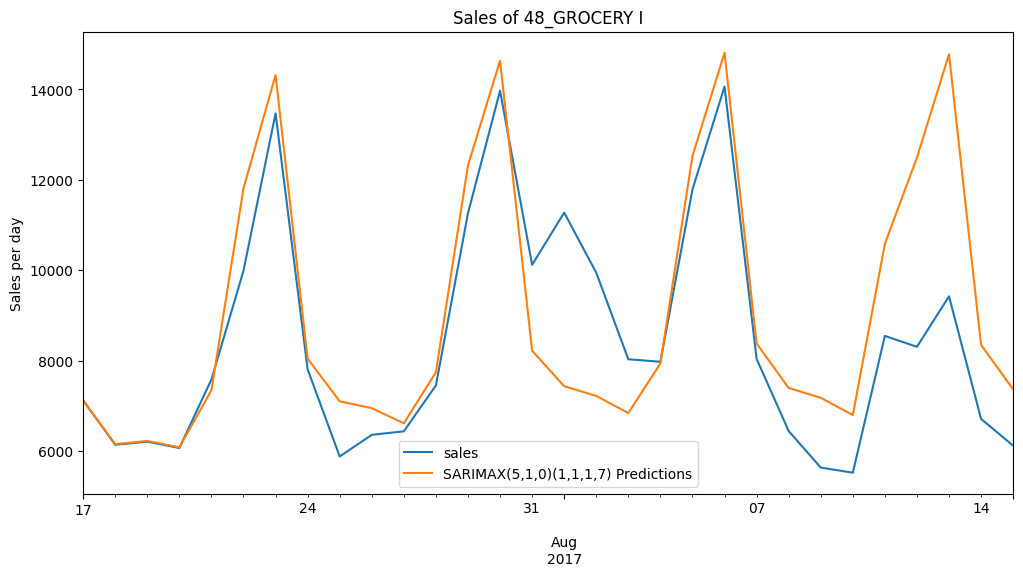

In [ ]:
# # Obtain predicted values
# start=len(train_arima)
# end=len(train_arima)+len(test_arima)-1
# exog_forecast = exog_test.copy()
# predictions = results.predict(start=start, end=end, exog=exog_test).rename('SARIMAX(5,1,0)(1,1,1,7) Predictions')
# # pred = np.expm1(predictions)
# pred = predictions
# # Plot predictions against known values
# title='Sales of 48_GROCERY I'
# ylabel='Sales per day'
# xlabel=''

# ax = test_arima['sales'].plot(legend=True,figsize=(12,6),title=title)
# pred.plot(legend=True)
# ax.autoscale(axis='x',tight=True)
# ax.set(xlabel=xlabel, ylabel=ylabel);

In [ ]:
# error1x = mean_squared_error(test_arima['sales'], pred)
# error2x = np.sqrt(error1x)
# # Print new SARIMAX values
# print(f'SARIMAX(5,1,2)(1,0,0,30) R2: {r2_score(test_arima['sales'], pred)}')
# print(f'SARIMAX(5,1,2)(1,0,0,30) MSE Error: {error1x:11.10}')
# print(f'SARIMAX(5,1,2)(1,0,0,30) RMSE Error: {error2x:11.10}')

SARIMAX(5,1,2)(1,0,0,30) R2: 0.17290865390125476
SARIMAX(5,1,2)(1,0,0,30) MSE Error: 5157521.798
SARIMAX(5,1,2)(1,0,0,30) RMSE Error: 2271.017789


In [ ]:
# model = SARIMAX(train_arima['sales'],exog=exog_train[['month','event_Dia_de_la_Madre','event_Cyber_Monday','holiday_local_binary','holiday_local_binary','holiday_national_binary']],order=(5,0,1),seasonal_order=(1,1,1,7),enforce_invertibility=False)
# results = model.fit()
# # results.summary()
# # specific = ['month','day_nbr']

c:\Users\Armando\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



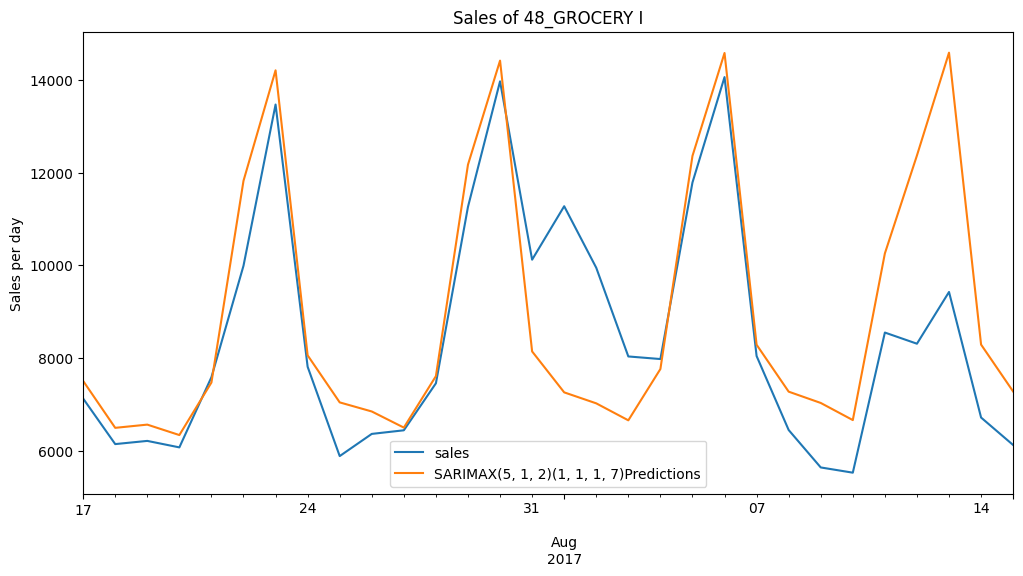

In [ ]:
# # Obtain predicted values
# start=len(train_arima)
# end=len(train_arima)+len(test_arima)-1
# exog_forecast = exog_test[['month','event_Dia_de_la_Madre','event_Cyber_Monday','holiday_local_binary','holiday_local_binary','holiday_national_binary']].copy()
# predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(5, 1, 2)(1, 1, 1, 7)Predictions')
# in_sample_preds = predictions

# # Plot predictions against known values
# title='Sales of 48_GROCERY I'
# ylabel='Sales per day'
# xlabel=''

# ax = test_arima['sales'].plot(legend=True,figsize=(12,6),title=title)
# predictions.plot(legend=True)
# ax.autoscale(axis='x',tight=True)
# ax.set(xlabel=xlabel, ylabel=ylabel);

In [ ]:
# error1x = mean_squared_error(test_arima['sales'], predictions)
# error2x = np.sqrt(error1x)

# # Print new SARIMAX values
# print(f'SARIMAX(2,1,2)(0,0,1,30) MSE Error: {error1x:11.10}')
# print(f'SARIMAX(2,1,2)(0,0,1,30) RMSE Error: {error2x:11.10}')
# print(f'SARIMAX(5,1,2)(1,0,0,30) R2: {r2_score(test_arima['sales'], predictions)}')


SARIMAX(2,1,2)(0,0,1,30) MSE Error: 3072141.271
SARIMAX(2,1,2)(0,0,1,30) RMSE Error: 1752.752484
SARIMAX(5,1,2)(1,0,0,30) R2: 0.5073328705467839


In [ ]:
# model = SARIMAX(my_series['sales'],exog=my_series[['month','event_Dia_de_la_Madre','event_Cyber_Monday','holiday_local_binary','holiday_national_binary']],order=(5,0,1),seasonal_order=(1,1,1,7),enforce_invertibility=False)
# results = model.fit()

c:\Users\Armando\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



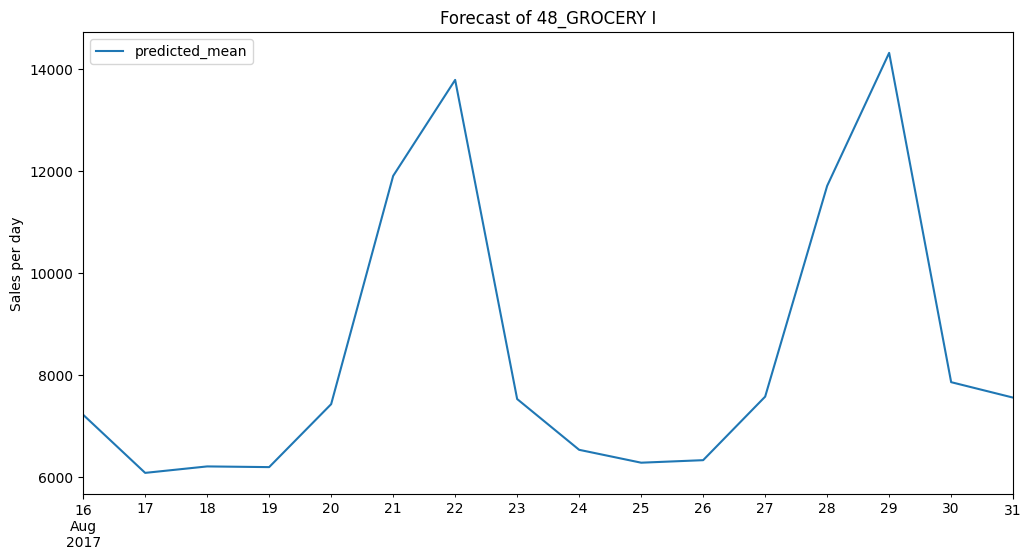

In [ ]:
# # Step 1: Train model (already done)
# # Step 2: Prepare future exog

# my_series_test_df = test_df[test_df['unique_id'] == '48_GROCERY I'].copy()
# exog_forecast = my_series_test_df[['month','event_Dia_de_la_Madre','event_Cyber_Monday','holiday_local_binary','holiday_national_binary']]

# # Step 3: Set forecast range
# start = len(train_arima)
# end = start + len(my_series_test_df) - 1
# end = start + len(my_series_test_df) - 1

# # Step 4: Forecast
# predictions = results.predict(start=start, end=end, exog=exog_forecast)
# future_preds = predictions
# # Step 5: Assign index if needed
# predictions.index = pd.to_datetime(my_series_test_df['date'])

# # Step 6: Plot
# ax = predictions.plot(figsize=(12,6), legend=True, title='Forecast of 48_GROCERY I')
# ax.set(xlabel='', ylabel='Sales per day');


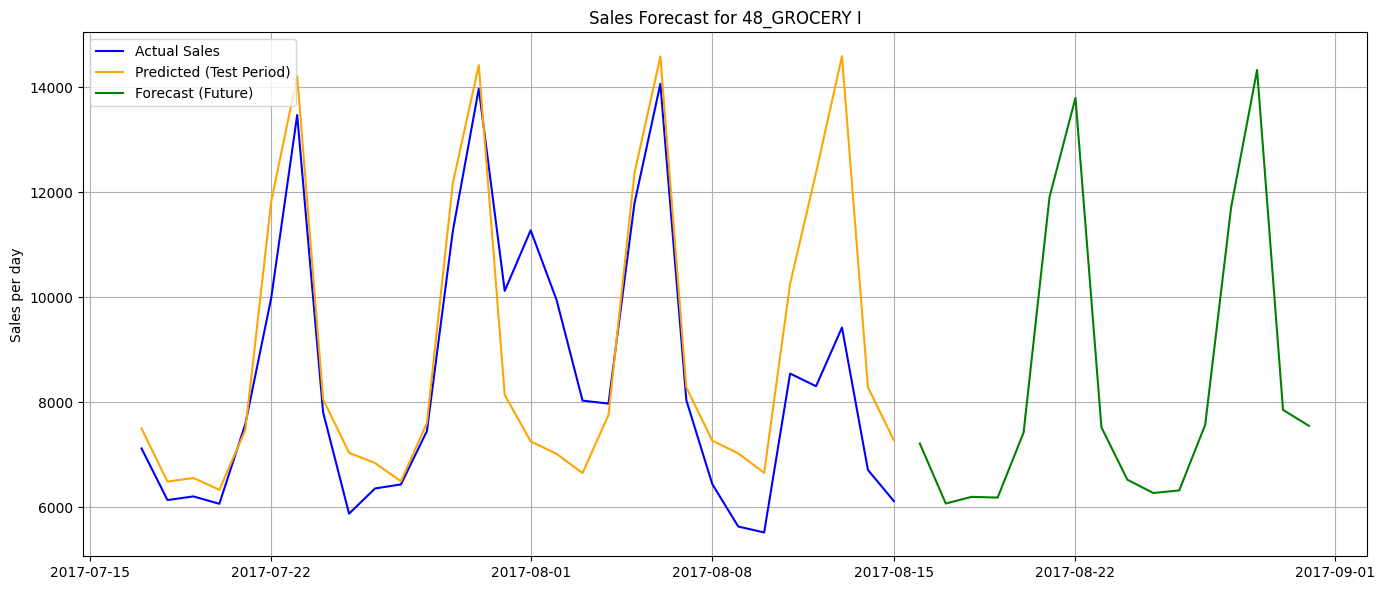

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(14, 6))
# plt.plot(test_arima.index, test_arima['sales'], label='Actual Sales', color='blue')
# plt.plot(in_sample_preds.index, in_sample_preds, label='Predicted (Test Period)', color='orange')
# plt.plot(future_preds.index, future_preds, label='Forecast (Future)', color='green')

# plt.title('Sales Forecast for 48_GROCERY I')
# plt.ylabel('Sales per day')
# plt.xlabel('')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


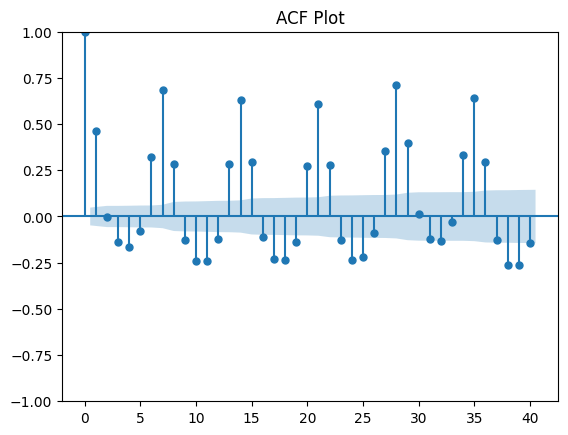

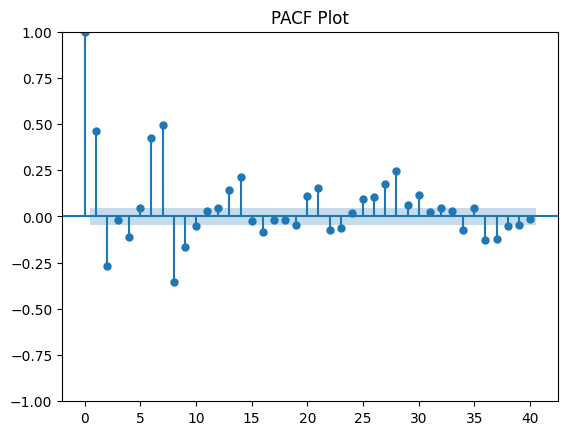

In [ ]:
# # Assuming you're working with a time series like:
# series = train_arima['sales']

# # Plot ACF
# plot_acf(series, lags=40)
# plt.title("ACF Plot")
# plt.show()

# # Plot PACF
# plot_pacf(series, lags=40, method='ywm')  # 'ywm' is preferred for stability
# plt.title("PACF Plot")
# plt.show()


In [ ]:
#Prophet

In [309]:
agg_df = df.groupby(['date','unique_id']).agg({'sales':'sum'}).reset_index().sort_values(['unique_id','date'])
total_sales_df = agg_df.pivot(index='date',columns='unique_id', values='sales')

In [310]:
total_sales_df.head()

unique_id   10_AUTOMOTIVE  10_BABY CARE  10_BEAUTY  10_BEVERAGES  10_BOOKS  \
date                                                                         
2013-01-01            0.0           0.0        0.0           0.0       0.0   
2013-01-02            3.0           0.0        6.0         396.0       0.0   
2013-01-03            2.0           0.0        3.0         399.0       0.0   
2013-01-04            2.0           0.0        4.0         460.0       0.0   
2013-01-05            0.0           0.0        3.0         624.0       0.0   

unique_id   10_BREAD/BAKERY  10_CELEBRATION  10_CLEANING  10_DAIRY  10_DELI  \
date                                                                          
2013-01-01              0.0             0.0          0.0       0.0      0.0   
2013-01-02            151.0             0.0       1110.0     101.0    276.0   
2013-01-03            129.0             0.0        970.0     113.0    269.0   
2013-01-04            105.0             0.0        669.0      66.0     92.0   
2013-01-05            112.0             0.0       1093.0      88.0    194.0   

unique_id   10_EGGS  10_FROZEN FOODS  10_GROCERY I  10_GROCERY II  \
date                                                                
2013-01-01      0.0            0.000           0.0            0.0   
2013-01-02     57.0           41.164        2579.0            8.0   
2013-01-03     38.0           14.470        1984.0            1.0   
2013-01-04     22.0           10.691        1565.0            2.0   
2013-01-05     43.0           13.891        2544.0            5.0   

unique_id   10_HARDWARE  10_HOME AND KITCHEN I  10_HOME AND KITCHEN II  \
date                                                                     
2013-01-01          0.0                    0.0                     0.0   
2013-01-02          2.0                    0.0                     0.0   
2013-01-03          0.0                    0.0                     0.0   
2013-01-04          0.0                    0.0                     0.0   
2013-01-05          3.0                    0.0                     0.0   

unique_id   10_HOME APPLIANCES  10_HOME CARE  10_LADIESWEAR  \
date                                                          
2013-01-01                 0.0           0.0            0.0   
2013-01-02                 0.0           0.0            0.0   
2013-01-03                 0.0           0.0            0.0   
2013-01-04                 0.0           0.0            0.0   
2013-01-05                 0.0           0.0            0.0   

unique_id   10_LAWN AND GARDEN  10_LINGERIE  10_LIQUOR,WINE,BEER  \
date                                                               
2013-01-01                 0.0          0.0                  0.0   
2013-01-02                 0.0          4.0                  6.0   
2013-01-03                 0.0          5.0                  2.0   
2013-01-04                 0.0          0.0                  8.0   
2013-01-05                 0.0          3.0                 26.0   

unique_id   10_MAGAZINES   10_MEATS  10_PERSONAL CARE  10_PET SUPPLIES  \
date                                                                     
2013-01-01           0.0    0.00000               0.0              0.0   
2013-01-02           0.0  291.14000             223.0              0.0   
2013-01-03           0.0  279.74298             169.0              0.0   
2013-01-04           0.0  139.16600             119.0              0.0   
2013-01-05           0.0  247.29800             270.0              0.0   

unique_id   10_PLAYERS AND ELECTRONICS  10_POULTRY  10_PREPARED FOODS  \
date                                                                    
2013-01-01                         0.0     0.00000                0.0   
2013-01-02                         0.0   146.78400               26.0   
2013-01-03                         0.0   148.31700               10.0   
2013-01-04                         0.0   111.15900                4.0   
2013-01-05          

In [311]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

In [ ]:
# total_sales_df.shape

In [312]:
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

In [314]:
def find_params_Prophet(feature='1_AUTOMOTIVE'):
  
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range,}

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
    rmses = [] 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="365 days", period="30 days", horizon = "30 days")
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        rmses.append(df_p["rmse"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["rmse"] = rmses
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("rmse").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    return params_dict

In [315]:
a = find_params_Prophet('48_GROCERY I')

21:45:37 - cmdstanpy - INFO - Chain [1] start processing
21:45:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:45:38 - cmdstanpy - INFO - Chain [1] start processing
21:45:38 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.33it/s]21:45:38 - cmdstanpy - INFO - Chain [1] start processing
21:45:38 - cmdstanpy - INFO - Chain [1] done processing
21:45:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:45:38 - cmdstanpy - INFO - Chain [1] start processing
21:45:39 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:01<00:24,  1.70it/s]21:45:39 - cmdstanpy - INFO - Chain [1] start processing
21:45:39 - cmdstanpy - INFO - Chain [1] done processing
21:45:39 - cmdstanpy - ERROR - Chain [1] erro

  horizon           mse        rmse          mae   mdape     smape  coverage
0 30 days  6.552369e+06  2559.75951  1876.958249  0.2089  0.238125  0.759848


21:46:02 - cmdstanpy - INFO - Chain [1] start processing
21:46:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:46:02 - cmdstanpy - INFO - Chain [1] start processing
21:46:02 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:10,  4.29it/s]21:46:03 - cmdstanpy - INFO - Chain [1] start processing
21:46:03 - cmdstanpy - INFO - Chain [1] done processing
21:46:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:46:03 - cmdstanpy - INFO - Chain [1] start processing
21:46:03 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:22,  1.89it/s]21:46:03 - cmdstanpy - INFO - Chain [1] start processing
21:46:03 - cmdstanpy - INFO - Chain [1] done processing
21:46:03 - cmdstanpy - ERROR - Chain [1] erro

  horizon           mse         rmse          mae    mdape     smape  coverage
0 30 days  6.287966e+06  2507.581681  1772.549107  0.18827  0.220901  0.762121


21:46:27 - cmdstanpy - INFO - Chain [1] start processing
21:46:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.70it/s]21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing
21:46:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:46:28 - cmdstanpy - INFO - Chain [1] start processing
21:46:28 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:01<00:24,  1.73it/s]21:46:29 - cmdstanpy - INFO - Chain [1] start processing
21:46:29 - cmdstanpy - INFO - Chain [1] done processing
21:46:29 - cmdstanpy - ERROR - Chain [1] erro

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  5.911384e+06  2431.333866  1735.178228  0.191849  0.218246   

   coverage  
0  0.775758  


21:46:52 - cmdstanpy - INFO - Chain [1] start processing
21:46:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:46:52 - cmdstanpy - INFO - Chain [1] start processing
21:46:52 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.65it/s]21:46:53 - cmdstanpy - INFO - Chain [1] start processing
21:46:53 - cmdstanpy - INFO - Chain [1] done processing
21:46:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:46:53 - cmdstanpy - INFO - Chain [1] start processing
21:46:54 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:02<00:50,  1.20s/it]21:46:55 - cmdstanpy - INFO - Chain [1] start processing
21:46:55 - cmdstanpy - INFO - Chain [1] done processing
21:46:55 - cmdstanpy - ERROR - Chain [1] erro

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  5.687406e+06  2384.828377  1698.440325  0.191563  0.214215   

   coverage  
0  0.778788  


21:47:18 - cmdstanpy - INFO - Chain [1] start processing
21:47:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:47:19 - cmdstanpy - INFO - Chain [1] start processing
21:47:19 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.58it/s]21:47:19 - cmdstanpy - INFO - Chain [1] start processing
21:47:19 - cmdstanpy - INFO - Chain [1] done processing
21:47:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:47:19 - cmdstanpy - INFO - Chain [1] start processing
21:47:20 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:01<00:27,  1.54it/s]21:47:20 - cmdstanpy - INFO - Chain [1] start processing
21:47:20 - cmdstanpy - INFO - Chain [1] done processing
21:47:20 - cmdstanpy - ERROR - Chain [1] erro

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  5.840316e+06  2416.674523  1730.388536  0.198363  0.217908   

   coverage  
0  0.770455  


21:47:46 - cmdstanpy - INFO - Chain [1] start processing
21:47:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:47:46 - cmdstanpy - INFO - Chain [1] start processing
21:47:47 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.50it/s]21:47:47 - cmdstanpy - INFO - Chain [1] start processing
21:47:47 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:09,  4.48it/s]21:47:47 - cmdstanpy - INFO - Chain [1] start processing
21:47:47 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:09,  4.31it/s]21:47:47 - cmdstanpy - INFO - Chain [1] start processing
21:47:47 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:00<00:09,  4.31it/s]21:47:47 - cmdstanpy - INFO - Chain [1] start processing
21:47:47 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  4.921220e+06  2218.382202  1585.815803  0.186174  0.203254   

   coverage  
0  0.819697  


21:48:00 - cmdstanpy - INFO - Chain [1] start processing
21:48:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:48:00 - cmdstanpy - INFO - Chain [1] start processing
21:48:00 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:10,  4.15it/s]21:48:01 - cmdstanpy - INFO - Chain [1] start processing
21:48:01 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:09,  4.28it/s]21:48:01 - cmdstanpy - INFO - Chain [1] start processing
21:48:01 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:09,  4.16it/s]21:48:01 - cmdstanpy - INFO - Chain [1] start processing
21:48:01 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:00<00:09,  4.15it/s]21:48:01 - cmdstanpy - INFO - Chain [1] start processing
21:48:01 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  4.509297e+06  2123.510461  1453.182697  0.162318  0.183861   

   coverage  
0  0.823485  


21:48:14 - cmdstanpy - INFO - Chain [1] start processing
21:48:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:48:14 - cmdstanpy - INFO - Chain [1] start processing
21:48:14 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.38it/s]21:48:14 - cmdstanpy - INFO - Chain [1] start processing
21:48:14 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:10,  3.92it/s]21:48:15 - cmdstanpy - INFO - Chain [1] start processing
21:48:15 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:10,  4.10it/s]21:48:15 - cmdstanpy - INFO - Chain [1] start processing
21:48:15 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:00<00:09,  4.12it/s]21:48:15 - cmdstanpy - INFO - Chain [1] start processing
21:48:15 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  4.508680e+06  2123.365232  1453.772603  0.161431  0.183926   

   coverage  
0  0.828788  


21:48:28 - cmdstanpy - INFO - Chain [1] start processing
21:48:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:48:28 - cmdstanpy - INFO - Chain [1] start processing
21:48:28 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.44it/s]21:48:28 - cmdstanpy - INFO - Chain [1] start processing
21:48:28 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:09,  4.53it/s]21:48:28 - cmdstanpy - INFO - Chain [1] start processing
21:48:28 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:09,  4.43it/s]21:48:29 - cmdstanpy - INFO - Chain [1] start processing
21:48:29 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:00<00:09,  4.01it/s]21:48:29 - cmdstanpy - INFO - Chain [1] start processing
21:48:29 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  4.508112e+06  2123.231411  1453.645693  0.161761  0.183914   

   coverage  
0     0.825  


21:48:41 - cmdstanpy - INFO - Chain [1] start processing
21:48:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:48:42 - cmdstanpy - INFO - Chain [1] start processing
21:48:42 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.47it/s]21:48:42 - cmdstanpy - INFO - Chain [1] start processing
21:48:42 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:09,  4.40it/s]21:48:42 - cmdstanpy - INFO - Chain [1] start processing
21:48:42 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:09,  4.30it/s]21:48:42 - cmdstanpy - INFO - Chain [1] start processing
21:48:42 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:00<00:09,  4.20it/s]21:48:42 - cmdstanpy - INFO - Chain [1] start processing
21:48:43 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  4.505324e+06  2122.574747  1453.103276  0.161981  0.183859   

   coverage  
0   0.82803  


21:48:55 - cmdstanpy - INFO - Chain [1] start processing
21:48:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:48:55 - cmdstanpy - INFO - Chain [1] start processing
21:48:55 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.59it/s]21:48:55 - cmdstanpy - INFO - Chain [1] start processing
21:48:55 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:09,  4.24it/s]21:48:56 - cmdstanpy - INFO - Chain [1] start processing
21:48:56 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:09,  4.28it/s]21:48:56 - cmdstanpy - INFO - Chain [1] start processing
21:48:56 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:00<00:09,  4.27it/s]21:48:56 - cmdstanpy - INFO - Chain [1] start processing
21:48:56 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  4.964493e+06  2228.114294  1589.464089  0.184789  0.203358   

   coverage  
0  0.812121  


21:49:09 - cmdstanpy - INFO - Chain [1] start processing
21:49:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:49:09 - cmdstanpy - INFO - Chain [1] start processing
21:49:09 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:11,  3.84it/s]21:49:09 - cmdstanpy - INFO - Chain [1] start processing
21:49:10 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:10,  4.03it/s]21:49:10 - cmdstanpy - INFO - Chain [1] start processing
21:49:10 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:10,  4.06it/s]21:49:10 - cmdstanpy - INFO - Chain [1] start processing
21:49:10 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:01<00:10,  3.77it/s]21:49:10 - cmdstanpy - INFO - Chain [1] start processing
21:49:10 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  4.519237e+06  2125.849801  1452.033188  0.161082  0.183509   

   coverage  
0  0.826515  


21:49:23 - cmdstanpy - INFO - Chain [1] start processing
21:49:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:49:23 - cmdstanpy - INFO - Chain [1] start processing
21:49:23 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.41it/s]21:49:24 - cmdstanpy - INFO - Chain [1] start processing
21:49:24 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:09,  4.24it/s]21:49:24 - cmdstanpy - INFO - Chain [1] start processing
21:49:24 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:10,  4.04it/s]21:49:24 - cmdstanpy - INFO - Chain [1] start processing
21:49:24 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:00<00:09,  4.14it/s]21:49:24 - cmdstanpy - INFO - Chain [1] start processing
21:49:24 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  4.515526e+06  2124.976598  1450.986269  0.160536  0.183347   

   coverage  
0  0.825758  


21:49:37 - cmdstanpy - INFO - Chain [1] start processing
21:49:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:49:38 - cmdstanpy - INFO - Chain [1] start processing
21:49:38 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.44it/s]21:49:38 - cmdstanpy - INFO - Chain [1] start processing
21:49:38 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:09,  4.27it/s]21:49:38 - cmdstanpy - INFO - Chain [1] start processing
21:49:38 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:09,  4.21it/s]21:49:39 - cmdstanpy - INFO - Chain [1] start processing
21:49:39 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:00<00:09,  4.04it/s]21:49:39 - cmdstanpy - INFO - Chain [1] start processing
21:49:39 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse        rmse          mae    mdape     smape  coverage
0 30 days  4.516213e+06  2125.13833  1451.163612  0.15999  0.183356  0.824242


21:49:51 - cmdstanpy - INFO - Chain [1] start processing
21:49:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:49:52 - cmdstanpy - INFO - Chain [1] start processing
21:49:52 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.48it/s]21:49:52 - cmdstanpy - INFO - Chain [1] start processing
21:49:52 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:09,  4.35it/s]21:49:52 - cmdstanpy - INFO - Chain [1] start processing
21:49:52 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:09,  4.20it/s]21:49:52 - cmdstanpy - INFO - Chain [1] start processing
21:49:52 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:00<00:09,  4.19it/s]21:49:53 - cmdstanpy - INFO - Chain [1] start processing
21:49:53 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape    smape  coverage
0 30 days  4.517496e+06  2125.440209  1451.892721  0.161692  0.18346  0.824242


21:50:05 - cmdstanpy - INFO - Chain [1] start processing
21:50:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:50:06 - cmdstanpy - INFO - Chain [1] start processing
21:50:06 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:10,  4.17it/s]21:50:06 - cmdstanpy - INFO - Chain [1] start processing
21:50:06 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:09,  4.23it/s]21:50:06 - cmdstanpy - INFO - Chain [1] start processing
21:50:06 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:09,  4.26it/s]21:50:07 - cmdstanpy - INFO - Chain [1] start processing
21:50:07 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:00<00:09,  4.31it/s]21:50:07 - cmdstanpy - INFO - Chain [1] start processing
21:50:07 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse        rmse          mae    mdape     smape  coverage
0 30 days  4.988581e+06  2233.51304  1588.171721  0.18304  0.202783  0.814394


21:50:20 - cmdstanpy - INFO - Chain [1] start processing
21:50:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:50:20 - cmdstanpy - INFO - Chain [1] start processing
21:50:20 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:10,  4.02it/s]21:50:20 - cmdstanpy - INFO - Chain [1] start processing
21:50:20 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:10,  4.10it/s]21:50:21 - cmdstanpy - INFO - Chain [1] start processing
21:50:21 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:10,  4.00it/s]21:50:21 - cmdstanpy - INFO - Chain [1] start processing
21:50:21 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:01<00:10,  3.75it/s]21:50:21 - cmdstanpy - INFO - Chain [1] start processing
21:50:21 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse      rmse          mae     mdape     smape  coverage
0 30 days  4.522496e+06  2126.616  1450.007107  0.158217  0.183097   0.82197


21:50:34 - cmdstanpy - INFO - Chain [1] start processing
21:50:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:50:34 - cmdstanpy - INFO - Chain [1] start processing
21:50:35 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:10,  4.27it/s]21:50:35 - cmdstanpy - INFO - Chain [1] start processing
21:50:35 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:10,  4.15it/s]21:50:35 - cmdstanpy - INFO - Chain [1] start processing
21:50:35 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:09,  4.18it/s]21:50:35 - cmdstanpy - INFO - Chain [1] start processing
21:50:35 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:00<00:09,  4.21it/s]21:50:35 - cmdstanpy - INFO - Chain [1] start processing
21:50:36 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape   smape  coverage
0 30 days  4.522603e+06  2126.641316  1450.040084  0.158295  0.1831  0.826515


21:50:48 - cmdstanpy - INFO - Chain [1] start processing
21:50:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:50:49 - cmdstanpy - INFO - Chain [1] start processing
21:50:49 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.49it/s]21:50:49 - cmdstanpy - INFO - Chain [1] start processing
21:50:49 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:09,  4.30it/s]21:50:49 - cmdstanpy - INFO - Chain [1] start processing
21:50:49 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:09,  4.17it/s]21:50:50 - cmdstanpy - INFO - Chain [1] start processing
21:50:50 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:00<00:09,  4.10it/s]21:50:50 - cmdstanpy - INFO - Chain [1] start processing
21:50:50 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  4.523762e+06  2126.913687  1450.757142  0.158692  0.183218   

   coverage  
0  0.823485  


21:51:03 - cmdstanpy - INFO - Chain [1] start processing
21:51:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:51:03 - cmdstanpy - INFO - Chain [1] start processing
21:51:03 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:11,  3.75it/s]21:51:03 - cmdstanpy - INFO - Chain [1] start processing
21:51:03 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:10,  3.89it/s]21:51:04 - cmdstanpy - INFO - Chain [1] start processing
21:51:04 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:10,  4.06it/s]21:51:04 - cmdstanpy - INFO - Chain [1] start processing
21:51:04 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:01<00:10,  3.97it/s]21:51:04 - cmdstanpy - INFO - Chain [1] start processing
21:51:04 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  4.522916e+06  2126.714809  1450.663974  0.158906  0.183181   

   coverage  
0     0.825  


21:51:17 - cmdstanpy - INFO - Chain [1] start processing
21:51:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:51:17 - cmdstanpy - INFO - Chain [1] start processing
21:51:17 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.44it/s]21:51:18 - cmdstanpy - INFO - Chain [1] start processing
21:51:18 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:09,  4.25it/s]21:51:18 - cmdstanpy - INFO - Chain [1] start processing
21:51:18 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:10,  3.92it/s]21:51:18 - cmdstanpy - INFO - Chain [1] start processing
21:51:18 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:00<00:10,  3.99it/s]21:51:18 - cmdstanpy - INFO - Chain [1] start processing
21:51:18 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  5.008019e+06  2237.860307  1588.786091  0.182829  0.202651   

   coverage  
0  0.810606  


21:51:32 - cmdstanpy - INFO - Chain [1] start processing
21:51:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:51:32 - cmdstanpy - INFO - Chain [1] start processing
21:51:32 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.32it/s]21:51:33 - cmdstanpy - INFO - Chain [1] start processing
21:51:33 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:09,  4.37it/s]21:51:33 - cmdstanpy - INFO - Chain [1] start processing
21:51:33 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:09,  4.12it/s]21:51:33 - cmdstanpy - INFO - Chain [1] start processing
21:51:33 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:00<00:10,  3.99it/s]21:51:33 - cmdstanpy - INFO - Chain [1] start processing
21:51:33 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  4.527920e+06  2127.890935  1449.775025  0.158324  0.183049   

   coverage  
0  0.822727  


21:51:47 - cmdstanpy - INFO - Chain [1] start processing
21:51:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:51:47 - cmdstanpy - INFO - Chain [1] start processing
21:51:47 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.31it/s]21:51:47 - cmdstanpy - INFO - Chain [1] start processing
21:51:47 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:10,  4.03it/s]21:51:47 - cmdstanpy - INFO - Chain [1] start processing
21:51:48 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:10,  3.89it/s]21:51:48 - cmdstanpy - INFO - Chain [1] start processing
21:51:48 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:00<00:10,  4.00it/s]21:51:48 - cmdstanpy - INFO - Chain [1] start processing
21:51:48 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  4.526225e+06  2127.492675  1450.144815  0.157809  0.183124   

   coverage  
0  0.821212  


21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:10,  4.13it/s]21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:02 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:11,  3.80it/s]21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:02 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:10,  3.85it/s]21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:02 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:01<00:10,  3.96it/s]21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:02 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape   smape  coverage
0 30 days  4.531711e+06  2128.781585  1451.842061  0.157444  0.1834  0.821212


21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/44 [00:00<?, ?it/s]21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/44 [00:00<00:09,  4.44it/s]21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 2/44 [00:00<00:10,  4.16it/s]21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:17 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 3/44 [00:00<00:09,  4.13it/s]21:52:17 - cmdstanpy - INFO - Chain [1] start processing
21:52:17 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 4/44 [00:00<00:09,  4.10it/s]21:52:17 - cmdstanpy - INFO - Chain [1] start processing
21:52:17 - cmdstanpy - INFO - Chain [1] done process

  horizon           mse         rmse          mae     mdape     smape  \
0 30 days  4.526432e+06  2127.541197  1449.771095  0.157672  0.183049   

   coverage  
0  0.827273  
48_GROCERY I
   changepoint_prior_scale  seasonality_prior_scale         rmse
0                    0.001                   0.0100  2559.759510
1                    0.001                   2.5075  2507.581681
2                    0.001                   5.0050  2431.333866
3                    0.001                   7.5025  2384.828377
4                    0.001                  10.0000  2416.674523


In [ ]:
# a

In [ ]:
prediction_days = 30
forecast_start_date = '2017-07-17'
def make_preds_Prophet(feature='1_AUTOMOTIVE',dicts={}):
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ['date','y']
    category_df[['y']] = category_df[['y']].apply(pd.to_numeric)
    category_df["date"] = pd.to_datetime(category_df["date"])

    temp = df[df['unique_id'] == feature].copy()

    temp = temp.drop(['id', 'store_nbr', 'family',
        'sales','city','state', 'type', 'cluster',
        'dcoilwtico', 'transactions','day','month_name',
        'holiday_national','holiday_regional',
        'holiday_local', 'event','unique_id','year','month','day_nbr',
        'holiday_national_binary','holiday_regional_binary','holiday_local_binary'],axis=1)
    temp = temp.drop_duplicates()
    temp = temp.drop_duplicates(subset='date')

    category_df["date"] = pd.to_datetime(category_df["date"])
    category_df= pd.merge(category_df,temp,on='date',how='left')
    category_df=category_df.drop_duplicates()
    category_df= category_df.drop_duplicates(subset=['date', 'y'])
    category_df= category_df.rename({"date":"ds"},axis=1)
    train_data = category_df[category_df['ds'] < forecast_start_date]
    test_data = category_df[category_df['ds'] >= forecast_start_date]
    test_data = test_data.drop(['y'],axis=1)
    
    #Holidays for each unique id & formating
    holiday_rows = df[
        (df['unique_id'] == feature) & (
        (df['holiday_national_binary'] == 1) |
        (df['holiday_regional_binary'] == 1) |
        (df['holiday_local_binary'] == 1))
    ].copy()
    dates = holiday_rows[['date']].copy()
    holidays_df = dates.merge(holidays_for_prophet, on='date', how='left').copy()
    holidays_df= holidays_for_prophet.rename(columns={'date': 'ds','description': 'holiday'})
    
    #model
    m = Prophet(changepoint_prior_scale = dicts['changepoint_prior_scale'],
                seasonality_prior_scale = dicts['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                holidays=holidays_df
                )
    # Add regressors
    regressors = category_df.columns.tolist()
    regressors.remove('ds') ; regressors.remove('y')
    # regressors.remove('onpromotion')
    for regressor in regressors:
        m.add_regressor(regressor)

    m.fit(train_data)

    future = m.make_future_dataframe(periods=prediction_days)
    future = pd.merge(future,category_df,on='ds',how='left')

    fcst_prophet_train = m.predict(future)
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(category_df)

    rmsle= np.sqrt(mean_squared_log_error(predicted_df['y'],predicted_df['yhat']))
    rmse = np.sqrt(mean_squared_error(predicted_df['y'], predicted_df['yhat']))
    r2 = r2_score(predicted_df['y'],predicted_df['yhat'])
    mape = calculate_mape(predicted_df['y'].values,predicted_df['yhat'].values)

    print(f"{feature}: RMSLE = {rmsle:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}, MAPE = {mape:.4f}")

    df_plot = pd.DataFrame({
        'date': predicted_df['ds'].unique(),
        'actual': predicted_df['y'].values,
        'predicted': predicted_df['yhat'].values,
        })

    plt.figure(figsize=(12, 6))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual Sales')
    plt.plot(df_plot['date'], df_plot['predicted'], label='Predictided Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f"Comparison of Actual and Predictided Sales of {feature} | RMSLE = {rmsle:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return df_plot

22:05:21 - cmdstanpy - INFO - Chain [1] start processing
22:05:22 - cmdstanpy - INFO - Chain [1] done processing


48_GROCERY I: RMSLE = 0.2039, RMSE = 1895.5690, R² = 0.4238, MAPE = 14.6532


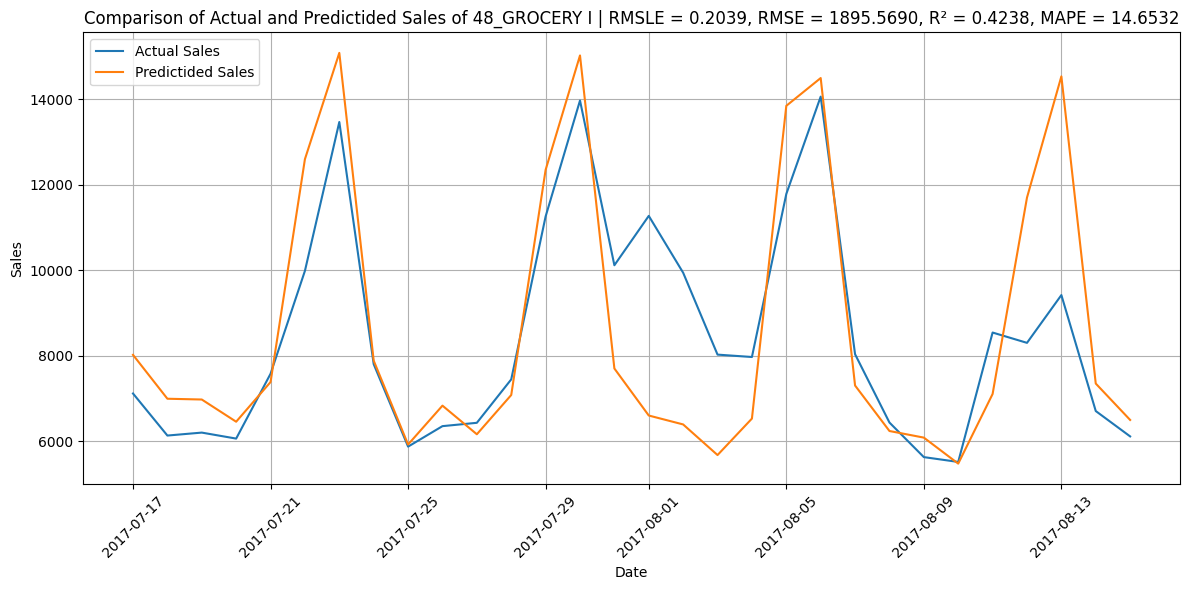

In [333]:
d = make_preds_Prophet(feature='48_GROCERY I',dicts=a)

In [335]:
forecast_start_date= max(total_sales_df.index)

def make_future_preds_Prophet(feature='1_AUTOMOTIVE',dicts={}):
    feature='48_GROCERY I';dicts=a
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ['date','y']
    category_df[['y']] = category_df[['y']].apply(pd.to_numeric)
    category_df["date"] = pd.to_datetime(category_df["date"])

    temp = df[df['unique_id'] == feature].copy()

    temp = temp.drop(['id', 'store_nbr', 'family',
        'sales','city','state', 'type', 'cluster',
        'dcoilwtico', 'transactions','day','month_name',
        'holiday_national','holiday_regional',
        'holiday_local', 'event','unique_id','year','month','day_nbr',
        'holiday_national_binary','holiday_regional_binary','holiday_local_binary'],axis=1)
    temp = temp.drop_duplicates()
    temp = temp.drop_duplicates(subset='date')

    category_df["date"] = pd.to_datetime(category_df["date"])
    category_df= pd.merge(category_df,temp,on='date',how='left')
    category_df=category_df.drop_duplicates()
    category_df= category_df.drop_duplicates(subset=['date', 'y'])
    category_df= category_df.rename({"date":"ds"},axis=1)
    train_data = category_df[category_df['ds'] <= forecast_start_date]

    test_data_temp = test_df[test_df['unique_id'] == feature].copy()
    test_data = test_data_temp.rename({"date":"ds"},axis=1)


    #Holidays for each unique id & formating
    holiday_rows = df[
        (df['unique_id'] == feature) & (
        (df['holiday_national_binary'] == 1) |
        (df['holiday_regional_binary'] == 1) |
        (df['holiday_local_binary'] == 1))
    ].copy()
    dates = holiday_rows[['date']].copy()
    holidays_df = dates.merge(holidays_for_prophet, on='date', how='left').copy()
    holidays_df= holidays_for_prophet.rename(columns={'date': 'ds','description': 'holiday'})

    #model
    m = Prophet(changepoint_prior_scale = dicts['changepoint_prior_scale'],
                seasonality_prior_scale = dicts['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                holidays=holidays_df
                )

    # Add regressors
    regressors = category_df.columns.tolist()
    regressors.remove('ds') ; regressors.remove('y')

    for regressor in regressors:
        m.add_regressor(regressor)

    m.fit(train_data)

    future = m.make_future_dataframe(periods=16)
    future = pd.merge(future,test_data,on='ds',how='left')
    for reg in regressors:
        if reg in future.columns:
            future[reg] = future[reg].fillna(0)
    fcst_prophet_train = m.predict(future)

    future_forecast = fcst_prophet_train[fcst_prophet_train['ds'] > forecast_start_date]

    # Plot only the forecasted days
    plt.figure(figsize=(12, 6))
    plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Predicted Sales (Future)')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f"Future Sales Forecast for {feature}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return future_forecast
# df_plot = pd.DataFrame({
#     'date': fcst_prophet_train['ds'],
#     'predicted': fcst_prophet_train['yhat'],
# })
# df_plot= df_plot[df_plot['date']> forecast_start_date].copy()
# plt.figure(figsize=(12, 6))
# plt.plot(df_plot['date'], df_plot['predicted'], label='Predictided Sales')
# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.title(f"Predictided Sales of {feature}")
# plt.legend()
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()    
# fig1 = m.plot(fcst_prophet_train)
# fig2 = m.plot_components(fcst_prophet_train)

# forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]

22:09:13 - cmdstanpy - INFO - Chain [1] start processing
22:09:13 - cmdstanpy - INFO - Chain [1] done processing


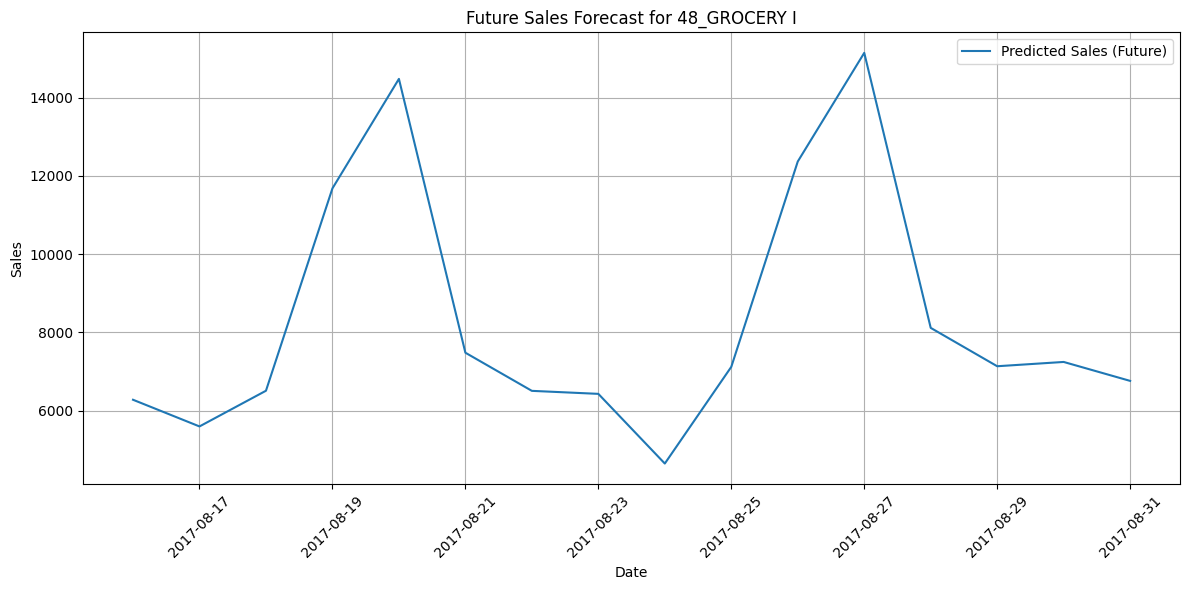

In [337]:
d2 = make_future_preds_Prophet('48_GROCERY I',a)

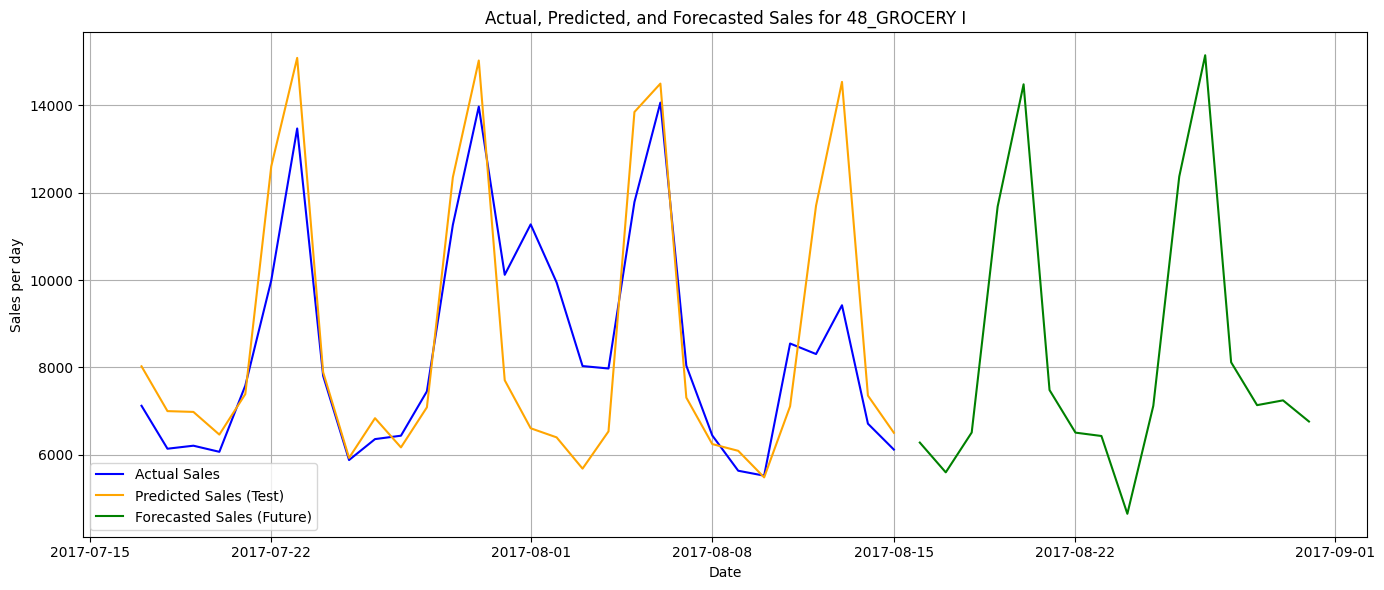

In [341]:
plt.figure(figsize=(14, 6))

# Plot actual vs predicted on test period
plt.plot(d['date'], d['actual'], label='Actual Sales', color='blue')
plt.plot(d['date'], d['predicted'], label='Predicted Sales (Test)', color='orange')

# Plot future predictions
plt.plot(d2['ds'], d2['yhat'], label='Forecasted Sales (Future)', color='green')

plt.title('Actual, Predicted, and Forecasted Sales for 48_GROCERY I')
plt.xlabel('Date')
plt.ylabel('Sales per day')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [339]:
d.head()

,date,actual,predicted
0,2017-07-17,7122.0,8025.110047
1,2017-07-18,6139.0,6999.566177
2,2017-07-19,6208.0,6981.448327
3,2017-07-20,6068.0,6462.355660
4,2017-07-21,7583.0,7389.359537


In [ ]:
#END OF PROPHET

In [ ]:
#df['lag_1'] = df.groupby(['store_nbr','family'])['sales'].shift(1)
#df['lag_7'] = df.groupby(['store_nbr','family'])['sales'].shift(7)
#df['rolling_mean_7'] = df.groupby(['store_nbr','family'])['sales'].transform(lambda x: x.shift(1).rolling(7).mean())
#df['rolling_mean_14'] = df.groupby(['store_nbr','family'])['sales'].transform(lambda x: x.shift(1).rolling(14).mean())
#df['rolling_std_7'] = df.groupby(['store_nbr','family'])['sales'].transform(lambda x: x.shift(1).rolling(7).std())
#df['oil_lag_14'] = df.groupby(['store_nbr','family'])['dcoilwtico'].shift(14)
df['lag_21'] = df.groupby(['store_nbr','family'])['sales'].shift(21)
df['lag_28'] = df.groupby(['store_nbr','family'])['sales'].shift(28)
df['oil_lag_21'] = df.groupby(['store_nbr','family'])['dcoilwtico'].shift(21)
df['oil_lag_28'] = df.groupby(['store_nbr','family'])['dcoilwtico'].shift(28)
df= df.dropna()

In [ ]:
agg_df = df.groupby(['date','unique_id']).agg({'sales':'sum'}).reset_index().sort_values(['unique_id','date'])
total_sales_df = agg_df.pivot(index='date',columns='unique_id', values='sales')

In [ ]:
#Choosing quality series
def quality_choose(feature):
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ['date','sales']
    non_zero_ratio = (category_df['sales'] != 0).sum() / len(category_df)
    cv = category_df['sales'].std() / category_df['sales'].mean()
    z = np.abs(stats.zscore(category_df['sales']))
    outlier_ratio = (z > 2.5).sum() / len(category_df)
    total = category_df['sales'].sum()
    
    # Check thresholds
    keep = not (non_zero_ratio < 0.25 or cv > 3 or cv <0.3 or outlier_ratio > 0.1)
    
    return pd.DataFrame([{
        'feature': feature,
        'non_zero_ratio': non_zero_ratio,
        'cv': cv,
        'outlier_ratio': outlier_ratio,
        'keep': keep,
        'total':total
    }])
results_df = pd.concat([quality_choose(col) for col in total_sales_df.columns], ignore_index=True)

In [ ]:
# 1. Get list of features to keep
features_to_keep = results_df[results_df['keep']]['feature'].tolist()

# 2. Filter total_sales_df to keep only high-quality series
total_sales_df = total_sales_df[features_to_keep].copy()

In [ ]:
total_sales_df.shape

In [ ]:
#LightGBM

In [ ]:
df= df.drop(event_cols,axis=1)

In [ ]:
df['day_of_month'] = df['date'].dt.day

In [ ]:
df['is_saturday'] = (df['day_nbr'] == 5).astype(int)
df['is_sunday'] = (df['day_nbr'] == 6).astype(int)
df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
df['dayofyear'] = df['date'].dt.dayofyear

In [ ]:
y = df[['date','sales']]
features = [
 'onpromotion',
 'day_nbr',
 'day_of_month',
 'year',
 'month',
 'holiday_national_binary',
 'lag_21',
 'lag_28',
 'oil_lag_21',
 'oil_lag_28',
 'is_saturday',
 'is_sunday',
 'weekofyear',
 'dayofyear'
 #'oil_lag_1',
 #'lag_7',
 #'lag_14',
 #'rolling_mean_7',
 #'rolling_mean_14',
 #'rolling_std_7',
 #'oil_lag_7',
 #'oil_lag_14',
 #'unique_id',
 #'family',                                  # αυτα ειναι ολα τα features που τεσταρα αλλα τελικα δεν κρατησα
 #'is_weekend',
 #'store_nbr',
 #'city',
 #'state',
 #'type',
 #'cluster',
 #'quarter',
 #'holiday_local_binary',
 #'holiday_regional_binary',
 #'lag_1',
 #'trans_lag_1',                                    # Αυτα ηταν lags για τα transactions
 #'trans_lag_7',
 #'trans_lag_14'
]

In [ ]:
#Tuning
def find_params_LightGBM(feature):
    #Extracting the series and formating so that the model has all the features
    category_df = total_sales_df[feature].copy().reset_index()
    temp = df[df['unique_id'] == feature].copy()
    category_df.columns = ["date", "sales"]

    temp = temp.drop(['id', 'store_nbr', 'family',
        'sales','city','state', 'type', 'cluster',
        'dcoilwtico', 'transactions','day','month_name',
        'holiday_national','holiday_regional',
        'holiday_local', 'event','unique_id'],axis=1)

    category_df["date"] = pd.to_datetime(category_df["date"])
    category_df= pd.merge(category_df,temp,on='date',how='left')
    category_df=category_df.drop_duplicates()
    category_df= category_df.drop_duplicates(subset=['date', 'sales'])
    category_df=category_df.dropna()

    y = category_df['sales']
    X = category_df[features].copy()
    #Grid search space
    param_grid = {
        'max_depth':[7],
        'num_leaves': [31,64],
        'learning_rate': [0.01,0.05, 0.1],
        'n_estimators': [1000],
        'reg_alpha': [0.0, 0.1],
        'reg_lambda': [0.0, 0.1],
        'min_child_samples': [20, 50]
    }

    lgb_reg = lgb.LGBMRegressor()
    #Cross validation
    tscv = TimeSeriesSplit(n_splits=6, test_size=16)

    grid = GridSearchCV(estimator=lgb_reg,
                        param_grid=param_grid,
                        cv=tscv,
                        scoring='neg_root_mean_squared_error',
                        verbose=0)
    grid.fit(X, y)

    best_params = grid.best_params_
    best_score = -grid.best_score_

    best_params_with_score = best_params.copy()
    best_params_with_score["rmse"] = best_score
    return best_params_with_score

In [ ]:
def do_cv(category_df,dicts={},n_splits=5):
    # Cross-validation mode
    X = category_df[features]
    y = category_df['sales']

    tscv = TimeSeriesSplit(n_splits=n_splits,test_size=16)
    rmses, rmsles, r2s = [], [], []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        for col in ['day_nbr']:
            X_train[col] = X_train[col].astype('category')
            X_val[col] = X_val[col].astype('category')

        model = LGBMRegressor(
            max_depth=dicts['max_depth'],
            num_leaves=dicts['num_leaves'],
            learning_rate=dicts['learning_rate'],
            n_estimators=dicts['n_estimators'],
            reg_alpha=dicts['reg_alpha'],
            reg_lambda=dicts['reg_lambda'],
            min_child_samples=dicts['min_child_samples'],
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(0, y_pred)))
        r2 = r2_score(y_val, np.maximum(0, y_pred))

        rmses.append(rmse)
        rmsles.append(rmsle)
        r2s.append(r2)

    avg_rmse = np.mean(rmses)
    avg_rmsle = np.mean(rmsles)
    avg_r2 = np.mean(r2s)

    temp1 = pd.DataFrame({
        "rmse": [avg_rmse],
        "rmsle": [avg_rmsle],
        "R²": [avg_r2],
    })

    print("Cross-Validation Results:")
    print(temp1)
    return temp1

In [ ]:

def make_preds_lightGBM(feature,dicts={},i=0):
    #Extracting the series and formating so that the model has all the features
    category_df = total_sales_df[feature].copy().reset_index()
    temp = df[df['unique_id'] == feature].copy()
    category_df.columns = ["date", "sales"]

    temp = temp.drop(['id', 'store_nbr', 'family',
        'sales','city','state', 'type', 'cluster',
        'dcoilwtico', 'transactions','day','month_name',
        'holiday_national','holiday_regional',
        'holiday_local', 'event','unique_id'],axis=1)

    category_df["date"] = pd.to_datetime(category_df["date"])
    category_df= pd.merge(category_df,temp,on='date',how='left')
    category_df=category_df.drop_duplicates()
    category_df= category_df.drop_duplicates(subset=['date', 'sales'])
    category_df=category_df.dropna()

    y = category_df[['date', 'sales']]
    features= category_df.columns.tolist()[2:]

    test_start='2017-07-31'
    X_train = category_df[category_df['date']<test_start].copy()
    y_train = y[y['date']<test_start].copy()

    X_val = category_df[category_df['date']>=test_start].copy()
    y_val = y[y['date']>=test_start].copy()
    dates_val = X_val['date'].copy()

    y_train = X_train['sales'].copy()
    y_val = y[y['date'] >= test_start]['sales'].copy()


    X_train = X_train[features]
    X_val = X_val[features]

    cat_cols = ['day_nbr']
    for col in cat_cols:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')
    
    
    
    model = LGBMRegressor(
        max_depth=dicts['max_depth'],
        num_leaves=dicts['num_leaves'],
        learning_rate=dicts['learning_rate'],
        n_estimators=dicts['n_estimators'],
        reg_alpha=dicts['reg_alpha'],
        reg_lambda=dicts['reg_lambda'],
        min_child_samples=dicts['min_child_samples'],
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(0, y_pred)))
    mape = calculate_mape(y_val, np.maximum(0, y_pred))
    r2 = r2_score(y_val, np.maximum(0, y_pred))
    m=category_df['sales'].mean()
    temp1 = pd.DataFrame({
                "unique_id":[feature],
                "rmse":[rmse],
                "ymean": [m],
                "rmsle":[rmsle],
                "mape":[mape],
                "R²":[r2],
                })
    
    #Keeping this data to make train-test plot values
    df_plot = pd.DataFrame({
                'date': dates_val,
                'actual': y_val,
                'predicted': y_pred
                })
    
    #Predictions vs Actual sales for said series
    daily_summary = df_plot.groupby('date')[['actual', 'predicted']].sum().reset_index()
    plt.figure(figsize=(12, 6))
    plt.plot(daily_summary['date'], daily_summary['actual'], label='Πραγματικές Πωλήσεις')
    plt.plot(daily_summary['date'], daily_summary['predicted'], label='Προβλεπόμενες Πωλήσεις')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f"Comparison of Actual and Predictided Sales of {feature} | RMSLE = {rmsle:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}, MAPE = {mape:.4f}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Feature importance (split count)
    importance_df = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=True)

    # Horizontal bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Split Count')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    # SHAP Explainer for tree-based models
    explainer = shap.Explainer(model)

    # Compute SHAP values
    shap_values = explainer(X_val)

    # Initialize SHAP JS 
    shap.initjs()

    # Waterfall plot for the first observation
    shap.plots.waterfall(shap_values[i])

    #Summary Plot
    shap.summary_plot(shap_values, X_val)

    temp2 = category_df.copy()
    temp2 = do_cv(category_df,dicts,n_splits=5)
    return temp1,temp2

In [ ]:
df.head()

In [ ]:
# A = find_params_LightGBM('3_PRODUCE') 

In [ ]:
# c,d=make_preds_lightGBM('3_PRODUCE',A) 

In [ ]:
# B = find_params_LightGBM('48_GROCERY I') ##

In [ ]:
# make_preds_lightGBM('48_GROCERY I',B,6) ##

In [ ]:
# C = find_params_LightGBM("44_BEVERAGES")

In [ ]:
# make_preds_lightGBM("47_BEVERAGES",A)

In [ ]:
test_df=test_df.drop(event_cols,axis=1)

In [ ]:
# test_df['day_of_month'] = test_df['date'].dt.day
# test_df['day_nbr'] = test_df['date'].dt.dayofweek
# test_df['month'] = test_df['date'].dt.month             # 1–12
# test_df['year'] = test_df['date'].dt.year
# test_df['is_saturday'] = (test_df['day_nbr'] == 5).astype(int)
# test_df['is_sunday'] = (test_df['day_nbr'] == 6).astype(int)
# test_df['weekofyear'] = test_df['date'].dt.isocalendar().week.astype(int)
# test_df['dayofyear'] = test_df['date'].dt.dayofyear

In [ ]:
full_df = pd.concat([df, test_df], axis=0).sort_values(['unique_id', 'date']).reset_index(drop=True)
full_df['lag_21'] = full_df.groupby(['store_nbr','family'])['sales'].shift(21)
full_df['lag_28'] = full_df.groupby(['store_nbr','family'])['sales'].shift(28)
full_df['oil_lag_21'] = full_df.groupby(['store_nbr','family'])['dcoilwtico'].shift(21)
full_df['oil_lag_28'] = full_df.groupby(['store_nbr','family'])['dcoilwtico'].shift(28)

In [ ]:
test_df.shape

In [ ]:
test_df = full_df[full_df['date'].isin(test_df['date'])]

In [ ]:
test_df.shape

In [ ]:
df.head()

In [ ]:
#  'onpromotion',
#  'day_nbr',
#  'day_of_month',
#  'year',
#  'month',
#  'holiday_national_binary',
#  'lag_21',
#  'lag_28',
#  'oil_lag_21',
#  'oil_lag_28',
#  'is_saturday',
#  'is_sunday',
#  'weekofyear',
#  'dayofyear'

In [ ]:
df_filtered = df[df['unique_id'].isin(features_to_keep)].copy()
len(df_filtered.unique_id.unique())
# df_filtered=df_filtered.drop(event_cols,axis=1)

In [ ]:
df.head()

In [ ]:
len(df_filtered.unique_id.unique())

In [ ]:
y = df_filtered[['date','sales']].copy()
features = [
 'onpromotion',
 'day_nbr',
 'day_of_month',
 'year',
 'month',
 'holiday_national_binary',
 'lag_21',
 'lag_28',
 'oil_lag_21',
 'oil_lag_28',
 'is_saturday',
 'is_sunday',
 'weekofyear',
 'dayofyear',
 'store_nbr',
 'family'
#  'oil_lag_1',
#  'lag_7',
#  'lag_14',
#  'lag_28',
#  'rolling_mean_7',
#  'rolling_mean_14',
#  'rolling_std_7',
#  'oil_lag_7',
#  'oil_lag_14',
]
X = df_filtered[features].copy()

In [ ]:
len(df_filtered.unique_id.unique())

In [ ]:
df.head()

[200]	valid_0's rmse: 0.443755	valid_0's l2: 0.196919
[300]	valid_0's rmse: 0.435473	valid_0's l2: 0.189637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's rmse: 0.430282	valid_0's l2: 0.185143
[500]	valid_0's rmse: 0.426247	valid_0's l2: 0.181686
[600]	valid_0's rmse: 0.42326	valid_0's l2: 0.179149
[700]	valid_0's rmse: 0.421052	valid_0's l2: 0.177285
[800]	valid_0's rmse: 0.419449	valid_0's l2: 0.175937
[900]	valid_0's rmse: 0.41772	valid_0's l2: 0.17449
[1000]	valid_0's rmse: 0.416683	valid_0's l2: 0.173625
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.416683	valid_0's l2: 0.173625


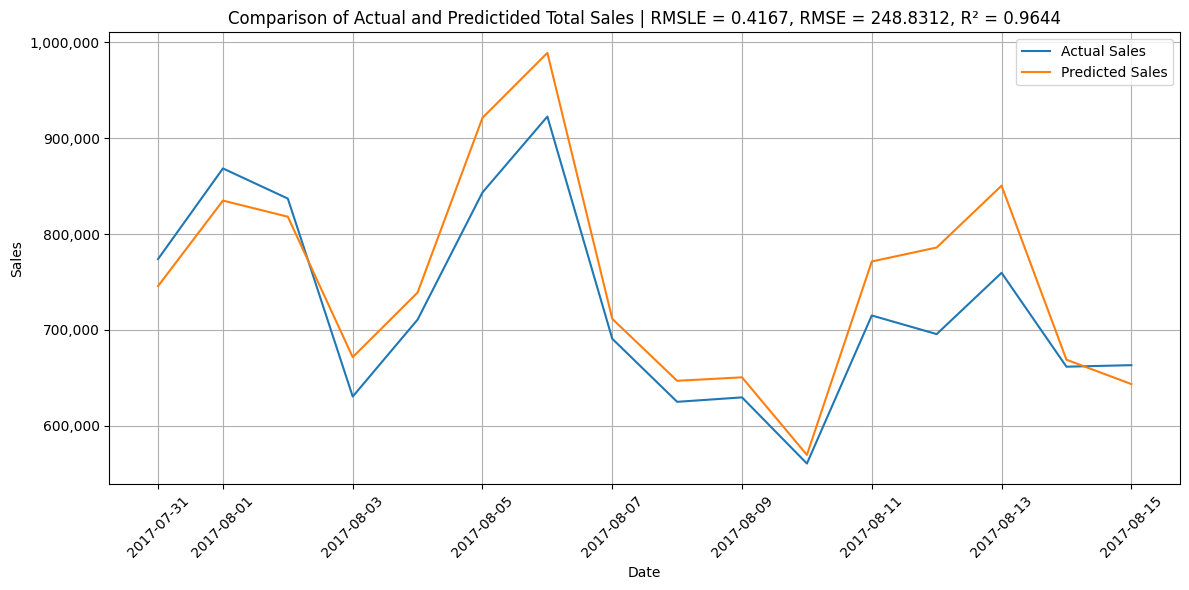

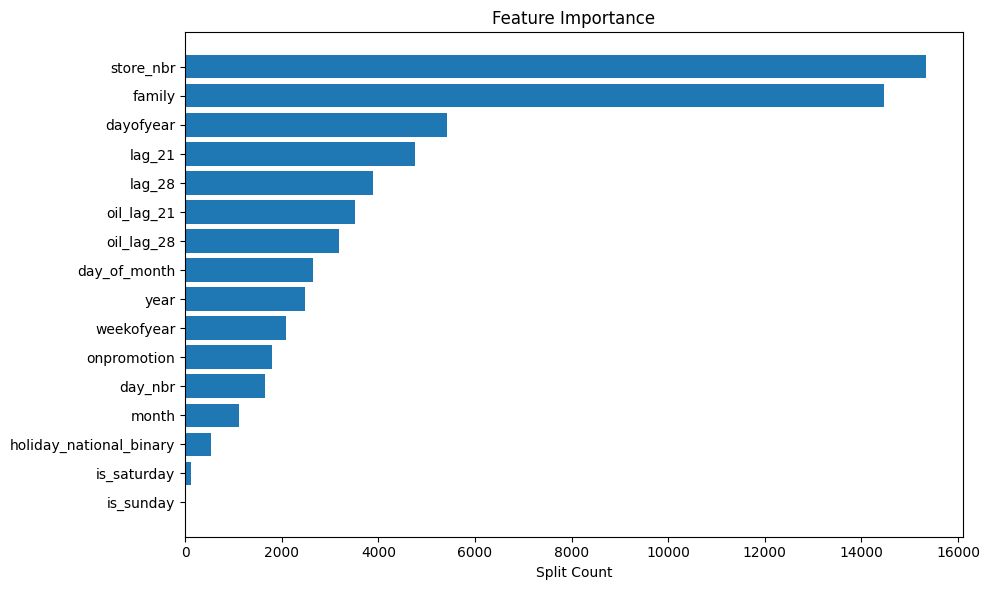

In [811]:
test_start='2017-07-31'
X_train = df_filtered[df_filtered['date']<test_start].copy()
y_train = y[y['date']<test_start].copy()

X_val = df_filtered[df_filtered['date']>=test_start].copy()
y_val = y[y['date']>=test_start].copy()
dates_val = y_val['date']


y_train = y_train['sales']
y_val = y_val['sales']

X_train = X_train[features]
X_val = X_val[features]

y_train = np.log1p(y_train)
y_val = np.log1p(y_val)

categorical_features = ['store_nbr','family']
cat_cols = ['store_nbr','family']
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

model = LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    categorical_feature=categorical_features,
    num_leaves=64,
    max_depth=7,
    learning_rate=0.05,
    n_estimators=1000,
    random_state=1,
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)]
)
y_pred = model.predict(X_val)

y_pred = np.expm1(y_pred)
y_val = np.expm1(y_val)

y_pred = np.maximum(0, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(0, y_pred)))
r2= r2_score(y_val, np.maximum(0, y_pred))
mape = calculate_mape(y_val, np.maximum(0, y_pred))
rmsle
rmse
r2

df_plot = pd.DataFrame({
    'date': dates_val,
    'actual': y_val,
    'predicted': y_pred
})

daily_summary = df_plot.groupby('date')[['actual', 'predicted']].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(daily_summary['date'], daily_summary['actual'], label='Actual Sales')
plt.plot(daily_summary['date'], daily_summary['predicted'], label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f"Comparison of Actual and Predictided Total Sales | RMSLE = {rmsle:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

# Feature importance (split count)
importance_df = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True)

# Horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Split Count')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
calculate_mape(y_val, np.maximum(0, y_pred))

In [812]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,day,year,month,month_name,day_nbr,holiday_national,holiday_regional,holiday_local,event,holiday_national_binary,holiday_regional_binary,holiday_local_binary,unique_id,lag_21,lag_28,oil_lag_21,oil_lag_28,day_of_month,is_saturday,is_sunday,weekofyear,dayofyear
49896,49896,2013-01-29,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,97.62,1772.0,Tuesday,2013,1,January,1,no_holiday,no_holiday,no_holiday,no_event,0,0,0,1_AUTOMOTIVE,2.0,0.0,93.21,93.14,29,0,0,5,29
51678,51678,2013-01-30,1,AUTOMOTIVE,6.0,0,Quito,Pichincha,D,13,97.98,1877.0,Wednesday,2013,1,January,2,no_holiday,no_holiday,no_holiday,no_event,0,0,0,1_AUTOMOTIVE,2.0,2.0,93.08,93.14,30,0,0,5,30
53460,53460,2013-01-31,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,97.65,0.0,Thursday,2013,1,January,3,no_holiday,no_holiday,no_holiday,no_event,0,0,0,1_AUTOMOTIVE,2.0,3.0,93.81,92.97,31,0,0,5,31
55242,55242,2013-02-01,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,97.46,1806.0,Friday,2013,2,February,4,no_holiday,no_holiday,no_holiday,no_event,0,0,0,1_AUTOMOTIVE,3.0,3.0,93.60,93.12,1,0,0,5,32
57024,57024,2013-02-02,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,97.46,0.0,Saturday,2013,2,February,5,no_holiday,no_holiday,no_holiday,no_event,0,0,0,1_AUTOMOTIVE,2.0,5.0,93.60,93.12,2,1,0,5,33


In [ ]:
rmse

In [813]:
test_df_filtered = test_df[test_df['unique_id'].isin(features_to_keep)].copy()
features = [
 'onpromotion',
 'day_nbr',
 'day_of_month',
 'year',
 'month',
 'holiday_national_binary',
 'lag_21',
 'lag_28',
 'oil_lag_21',
 'oil_lag_28',
 'is_saturday',
 'is_sunday',
 'weekofyear',
 'dayofyear',
 'store_nbr',
 'family']
pred_data= test_df_filtered[features].copy()
cat_cols = ['store_nbr','family']
for col in cat_cols:
    pred_data[col] =  pred_data[col].astype('category')
    pred_data[col] =  pred_data[col].astype('category')

In [814]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,day,year,month,month_name,day_nbr,holiday_national,holiday_regional,holiday_local,event,holiday_national_binary,holiday_regional_binary,holiday_local_binary,unique_id,lag_21,lag_28,oil_lag_21,oil_lag_28,day_of_month,is_saturday,is_sunday,weekofyear,dayofyear
49896,49896,2013-01-29,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,97.62,1772.0,Tuesday,2013,1,January,1,no_holiday,no_holiday,no_holiday,no_event,0,0,0,1_AUTOMOTIVE,2.0,0.0,93.21,93.14,29,0,0,5,29
51678,51678,2013-01-30,1,AUTOMOTIVE,6.0,0,Quito,Pichincha,D,13,97.98,1877.0,Wednesday,2013,1,January,2,no_holiday,no_holiday,no_holiday,no_event,0,0,0,1_AUTOMOTIVE,2.0,2.0,93.08,93.14,30,0,0,5,30
53460,53460,2013-01-31,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,97.65,0.0,Thursday,2013,1,January,3,no_holiday,no_holiday,no_holiday,no_event,0,0,0,1_AUTOMOTIVE,2.0,3.0,93.81,92.97,31,0,0,5,31
55242,55242,2013-02-01,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,97.46,1806.0,Friday,2013,2,February,4,no_holiday,no_holiday,no_holiday,no_event,0,0,0,1_AUTOMOTIVE,3.0,3.0,93.60,93.12,1,0,0,5,32
57024,57024,2013-02-02,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,97.46,0.0,Saturday,2013,2,February,5,no_holiday,no_holiday,no_holiday,no_event,0,0,0,1_AUTOMOTIVE,2.0,5.0,93.60,93.12,2,1,0,5,33


In [ ]:
y_pred = model.predict(pred_data)

In [ ]:
y_pred = np.expm1(y_pred)

In [ ]:
test_df_filtered = test_df_filtered.copy()
test_df_filtered['predicted_sales'] = y_pred

In [ ]:
total_predictions = test_df_filtered.groupby('date')['predicted_sales'].sum().reset_index()


In [ ]:
daily_summary_pred = test_df_filtered.groupby('date')[['predicted_sales']].sum().reset_index()
# plt.figure(figsize=(12, 6))
# plt.plot(daily_summary_pred['date'], daily_summary_pred['predicted_sales'], label='Προβλεπόμενες Πωλήσεις')

# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.title('Predicted Total Daily Sales')
# plt.legend()
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [ ]:
# Rename the prediction-only DataFrame
daily_summary_pred = daily_summary_pred.rename(columns={'predicted_sales': 'predicted'})
daily_summary_pred['actual'] = np.nan  # no actuals for this period
combined = pd.concat([daily_summary, daily_summary_pred], axis=0).sort_values('date').reset_index(drop=True)

# plt.figure(figsize=(12, 6))

# # First: Actuals in blue (default)
# plt.plot(combined['date'], combined['actual'], label='Πραγματικές Πωλήσεις')

# # Second: Predictions in orange (second default color)
# plt.plot(combined['date'], combined['predicted'], label='Προβλεπόμενες Πωλήσεις', linestyle='--')

# plt.xlabel('Ημερομηνία')
# plt.ylabel('Πωλήσεις')
# plt.title('Πραγματικές και Προβλεπόμενες Ημερήσιες Πωλήσεις')
# plt.legend()
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()



In [ ]:
# Σημείο αλλαγής (π.χ. τέλος validation)
cutoff_date = pd.to_datetime('2017-08-15')

# Προβλέψεις εντός validation (κανονική γραμμή)
mask_val = combined['date'] <= cutoff_date
# Προβλέψεις μετά (προβλέψεις μέλλοντος — διακεκομμένη)
mask_future = combined['date'] > cutoff_date


In [ ]:
# Σημείο αλλαγής (π.χ. τέλος validation)
cutoff_date = pd.to_datetime('2017-08-15')

# Προβλέψεις εντός validation (κανονική γραμμή)
mask_val = combined['date'] <= cutoff_date
# Προβλέψεις μετά (προβλέψεις μέλλοντος — διακεκομμένη)
mask_future = combined['date'] > cutoff_date

plt.figure(figsize=(12, 6))

# Πραγματικές πωλήσεις (μπλε)
plt.plot(combined['date'], combined['actual'], label='Actual Sales')

# Προβλέψεις εντός validation (πορτοκαλί, κανονική)
plt.plot(combined.loc[mask_val, 'date'], combined.loc[mask_val, 'predicted'],
         label='Predicted Sales', color='orange')

# Προβλέψεις μέλλοντος (πορτοκαλί, διακεκομμένη)
plt.plot(combined.loc[mask_future, 'date'], combined.loc[mask_future, 'predicted'],
         linestyle='--', color='orange')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual and Predicted Total Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

In [ ]:
#XGBoost

In [ ]:
# df = df[~df['unique_id'].isin(zero_sales['unique_id'])]
# df= df.drop(event_cols,axis=1)

In [ ]:
y = df[['date','sales']]
features = [
 'onpromotion',
 'day_nbr',
 'year',
 'month',
 'holiday_national_binary',
 'unique_id',
 'lag_21',
 'lag_28',
 'oil_lag_21',
 'oil_lag_28',
 #'rolling_mean_7',                            # αυτα ειναι ολα τα features που τεσταρα αλλα τελικα δεν κρατησα
 #'rolling_mean_14',
 #'rolling_std_7',
 #'oil_lag_1',
 #'lag_7',
 #'family',                                  
 #'is_weekend',
 #'store_nbr',
 #'city',
 #'state',
 #'type',
 #'cluster',
 #'quarter',
 #'holiday_local_binary',
 #'holiday_regional_binary',
 #'lag_1',
 #'trans_lag_1',                                    # Αυτα ηταν lags για τα transactions
 #'trans_lag_7',
 #'trans_lag_14'
]
X = df[features].copy()

In [ ]:
# df_sorted = results_df.sort_values(by='total', ascending=False)

In [817]:
df.shape

(2958120, 34)

In [ ]:
# test_start='2017-07-15'
# X_train = df[df['date']<test_start].copy()
# y_train = y[y['date']<test_start].copy()

# X_val = df[df['date']>=test_start].copy()
# y_val = y[y['date']>=test_start].copy()
# dates_val = y_val['date']
# y_train = y_train['sales']
# y_val = y_val['sales']


# X_train = X_train[features]
# X_val = X_val[features]

# # clip_threshold = y_train.quantile(0.995)
# # y_train = y_train.clip(upper=clip_threshold)
# # y_val= y_val.clip(upper=clip_threshold)

# cat_cols = ['unique_id']
# for col in cat_cols:
#     X_train[col] = X_train[col].astype('category')
#     X_val[col] = X_val[col].astype('category')

# reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
#                         enable_categorical=True,  
#                         n_estimators=1000,
#                         early_stopping_rounds=50,
#                         objective='reg:linear',
#                         max_depth=7,
#                         learning_rate=0.05,
#                         random_state=1
#                         )
# reg.fit(X_train, y_train,
#         eval_set=[(X_train, y_train), (X_val, y_val)],
#         verbose=100)

# y_pred = reg.predict(X_val)
# rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# df_plot = pd.DataFrame({
#     'date': dates_val,
#     'actual': y_val,
#     'predicted': y_pred
# })

# y_val_clipped = np.maximum(y_val, 0)
# y_pred_clipped = np.maximum(y_pred, 0)

# r2 = r2_score(y_val_clipped, y_pred_clipped)
# rmsle = np.sqrt(mean_squared_log_error(y_val_clipped, y_pred_clipped))
# rmse = np.sqrt(mean_squared_error(y_val_clipped, y_pred_clipped))
# print(r2,rmsle,rmse)

In [ ]:
plot_importance(reg, max_num_features=20)
plt.show()

In [ ]:
df_plot = pd.DataFrame({
    'date': dates_val,
    'actual': y_val_clipped,
    'predicted': y_pred_clipped
})

daily_summary = df_plot.groupby('date')[['actual', 'predicted']].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(daily_summary['date'], daily_summary['actual'], label='Πραγματικές Πωλήσεις')
plt.plot(daily_summary['date'], daily_summary['predicted'], label='Προβλεπόμενες Πωλήσεις')
plt.xlabel('Ημερομηνία')
plt.ylabel('Πωλήσεις')
plt.title('Σύγκριση Ημερήσιων Πραγματικών και Προβλεπόμενων Πωλήσεων')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
agg_df = df.groupby(['date','unique_id']).agg({'sales':'sum'}).reset_index().sort_values(['unique_id','date'])
total_sales_df = agg_df.pivot(index='date',columns='unique_id', values='sales')

In [ ]:
def make_preds_xgb(feature):
    category_df = total_sales_df[feature].copy().reset_index()
    temp = df[df['unique_id'] == feature].copy()
    category_df.columns = ["date", "sales"]

    temp = temp.drop(['id', 'store_nbr', 'family',
        'sales','city','state', 'type', 'cluster',
        'dcoilwtico', 'transactions','day','month_name',
        'holiday_national','holiday_regional',
        'holiday_local', 'event','unique_id'],axis=1)

    category_df["date"] = pd.to_datetime(category_df["date"])
    category_df= pd.merge(category_df,temp,on='date',how='left')
    category_df=category_df.drop_duplicates()
    category_df= category_df.drop_duplicates(subset=['date', 'sales'])
    category_df=category_df.dropna()

    y = category_df[['date', 'sales']]
    features= category_df.columns.tolist()[2:]

    test_start='2017-07-15'
    X_train = category_df[category_df['date']<test_start].copy()
    y_train = y[y['date']<test_start].copy()

    X_val = category_df[category_df['date']>=test_start].copy()
    y_val = y[y['date']>=test_start].copy()
    dates_val = y_val['date']

    y_train = y_train.drop(['date'],axis=1)
    y_val = y_val.drop(['date'],axis=1)

    X_train = X_train[features]
    X_val = X_val[features]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
                            enable_categorical=True,  
                            n_estimators=1000,
                            early_stopping_rounds=50,
                            objective='reg:linear',
                            max_depth=7,
                            learning_rate=0.05,
                            random_state=1
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(0, y_pred)))

    m=category_df['sales'].mean()
    temp1 = pd.DataFrame({
                "unique_id":[feature],
                "rmse":[rmse],
                "ymean": [m],
                "rmsle":[rmsle],
                })
    return temp1

In [818]:
original = df.copy()

In [ ]:
df= original.copy()

In [819]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,day,year,month,month_name,day_nbr,holiday_national,holiday_regional,holiday_local,event,holiday_national_binary,holiday_regional_binary,holiday_local_binary,unique_id,lag_21,lag_28,oil_lag_21,oil_lag_28,day_of_month,is_saturday,is_sunday,weekofyear,dayofyear
49896,49896,2013-01-29,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,97.62,1772.0,Tuesday,2013,1,January,1,no_holiday,no_holiday,no_holiday,no_event,0,0,0,1_AUTOMOTIVE,2.0,0.0,93.21,93.14,29,0,0,5,29
51678,51678,2013-01-30,1,AUTOMOTIVE,6.0,0,Quito,Pichincha,D,13,97.98,1877.0,Wednesday,2013,1,January,2,no_holiday,no_holiday,no_holiday,no_event,0,0,0,1_AUTOMOTIVE,2.0,2.0,93.08,93.14,30,0,0,5,30
53460,53460,2013-01-31,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,97.65,0.0,Thursday,2013,1,January,3,no_holiday,no_holiday,no_holiday,no_event,0,0,0,1_AUTOMOTIVE,2.0,3.0,93.81,92.97,31,0,0,5,31
55242,55242,2013-02-01,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,97.46,1806.0,Friday,2013,2,February,4,no_holiday,no_holiday,no_holiday,no_event,0,0,0,1_AUTOMOTIVE,3.0,3.0,93.60,93.12,1,0,0,5,32
57024,57024,2013-02-02,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,97.46,0.0,Saturday,2013,2,February,5,no_holiday,no_holiday,no_holiday,no_event,0,0,0,1_AUTOMOTIVE,2.0,5.0,93.60,93.12,2,1,0,5,33


In [820]:
df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster', 'dcoilwtico', 'transactions', 'day', 'year',
       'month', 'month_name', 'day_nbr', 'holiday_national',
       'holiday_regional', 'holiday_local', 'event', 'holiday_national_binary',
       'holiday_regional_binary', 'holiday_local_binary', 'unique_id',
       'lag_21', 'lag_28', 'oil_lag_21', 'oil_lag_28', 'day_of_month',
       'is_saturday', 'is_sunday', 'weekofyear', 'dayofyear'],
      dtype='object')

In [822]:
df=df.rename({"date":"ds","sales":"y"},axis=1)

In [826]:
df = df[['unique_id',
         'ds','y',
         'onpromotion',
         'year','month',
         'day_nbr',
         'holiday_national_binary',
         'holiday_regional_binary','holiday_local_binary',
         'lag_21','lag_28','oil_lag_21','oil_lag_28',
         'day_of_month','is_saturday','is_sunday','weekofyear','dayofyear']]  # Only id, timestamp, and target


In [827]:
# df = df[['unique_id', 'ds', 'y']]  # Only id, timestamp, and target
horizon = 16

# Define the model
nhits = NHITS(
    h=horizon,
    input_size=28,           # Match your lag features or desired lookback window
    loss=RMSE(),
    max_steps=1000,
    val_check_steps=50,
    random_seed=1,
    futr_exog_list =['onpromotion',
                    'year','month',
                    'day_nbr',
                    'holiday_national_binary',
                    'holiday_regional_binary','holiday_local_binary',
                    'lag_21','lag_28','oil_lag_21','oil_lag_28',
                    'day_of_month','is_saturday','is_sunday','weekofyear','dayofyear']
)

# Wrap in NeuralForecast
nf = NeuralForecast(models=[nhits], freq='D')

# Fit the model
nf.fit(df=df,val_size=horizon)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | RMSE          | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.690    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 17:  86%|████████▌ | 48/56 [00:02<00:00, 23.69it/s, v_num=15, train_loss_step=423.0, valid_loss=268.0, train_loss_epoch=280.0]  

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 17:  86%|████████▌ | 48/56 [00:02<00:00, 23.64it/s, v_num=15, train_loss_step=423.0, valid_loss=268.0, train_loss_epoch=280.0]


In [828]:
import logging

import optuna
import ray.tune as tune
import torch

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)
torch.set_float32_matmul_precision('high')

In [829]:
def config_nhits(trial):
    return {
        "input_size": trial.suggest_categorical(          # Length of input window
            "input_size", (48, 48*2, 48*3)                
        ),                                                
        "start_padding_enabled": True,                                          
        "n_blocks": 5 * [1],                              # Length of input window
        "mlp_units": 5 * [[64, 64]],                      # Length of input window
        "n_pool_kernel_size": trial.suggest_categorical(
            "n_pool_kernel_size",
            ((1, 1, 1, 1, 1), (2, 2, 2, 2, 2), (4, 4, 4, 4, 4), (8, 4, 2, 1, 1))
        )
        ,     
        "n_freq_downsample": trial.suggest_categorical(   # Interpolation expressivity ratios
            "n_freq_downsample",
            ([8, 4, 2, 1, 1],  [1, 1, 1, 1, 1])
        ),     
        "learning_rate": trial.suggest_float(             # Initial Learning rate
            "learning_rate",
            low=1e-4,
            high=1e-2,
            log=True,
        ),            
        "scaler_type": None,                              # Scaler type
        "max_steps": 1000,                                # Max number of training iterations
        "batch_size": trial.suggest_categorical(          # Number of series in batch
            "batch_size",
            (1, 4, 10),
        ),                   
        "windows_batch_size": trial.suggest_categorical(  # Number of windows in batch
            "windows_batch_size",
            (128, 256, 512),
        ),      
        "random_seed": trial.suggest_int(                 # Random seed   
            "random_seed",
            low=1,
            high=20,
        ),                      
    }

In [830]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=16, config=config_nhits, loss=MQLoss(), backend='optuna', num_samples=5)
    ],
    freq='D',
)

In [ ]:
nf.fit(df=df)

In [832]:
fcst_df = nf.predict()
fcst_df.columns = fcst_df.columns.str.replace('-median', '')
fcst_df.head()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 179/179 [00:01<00:00, 155.35it/s]


,unique_id,ds,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90
0,10_AUTOMOTIVE,2017-08-16,2.067258,0.633126,0.908890,3.954394,5.297094
1,10_AUTOMOTIVE,2017-08-17,1.402790,-0.136964,0.253066,3.384892,3.829494
2,10_AUTOMOTIVE,2017-08-18,1.658346,-0.096603,0.181554,3.262380,4.391099
3,10_AUTOMOTIVE,2017-08-19,1.214937,-0.256038,0.077127,3.308657,4.414412
4,10_AUTOMOTIVE,2017-08-20,1.861960,-0.046386,0.814138,3.515781,3.644654


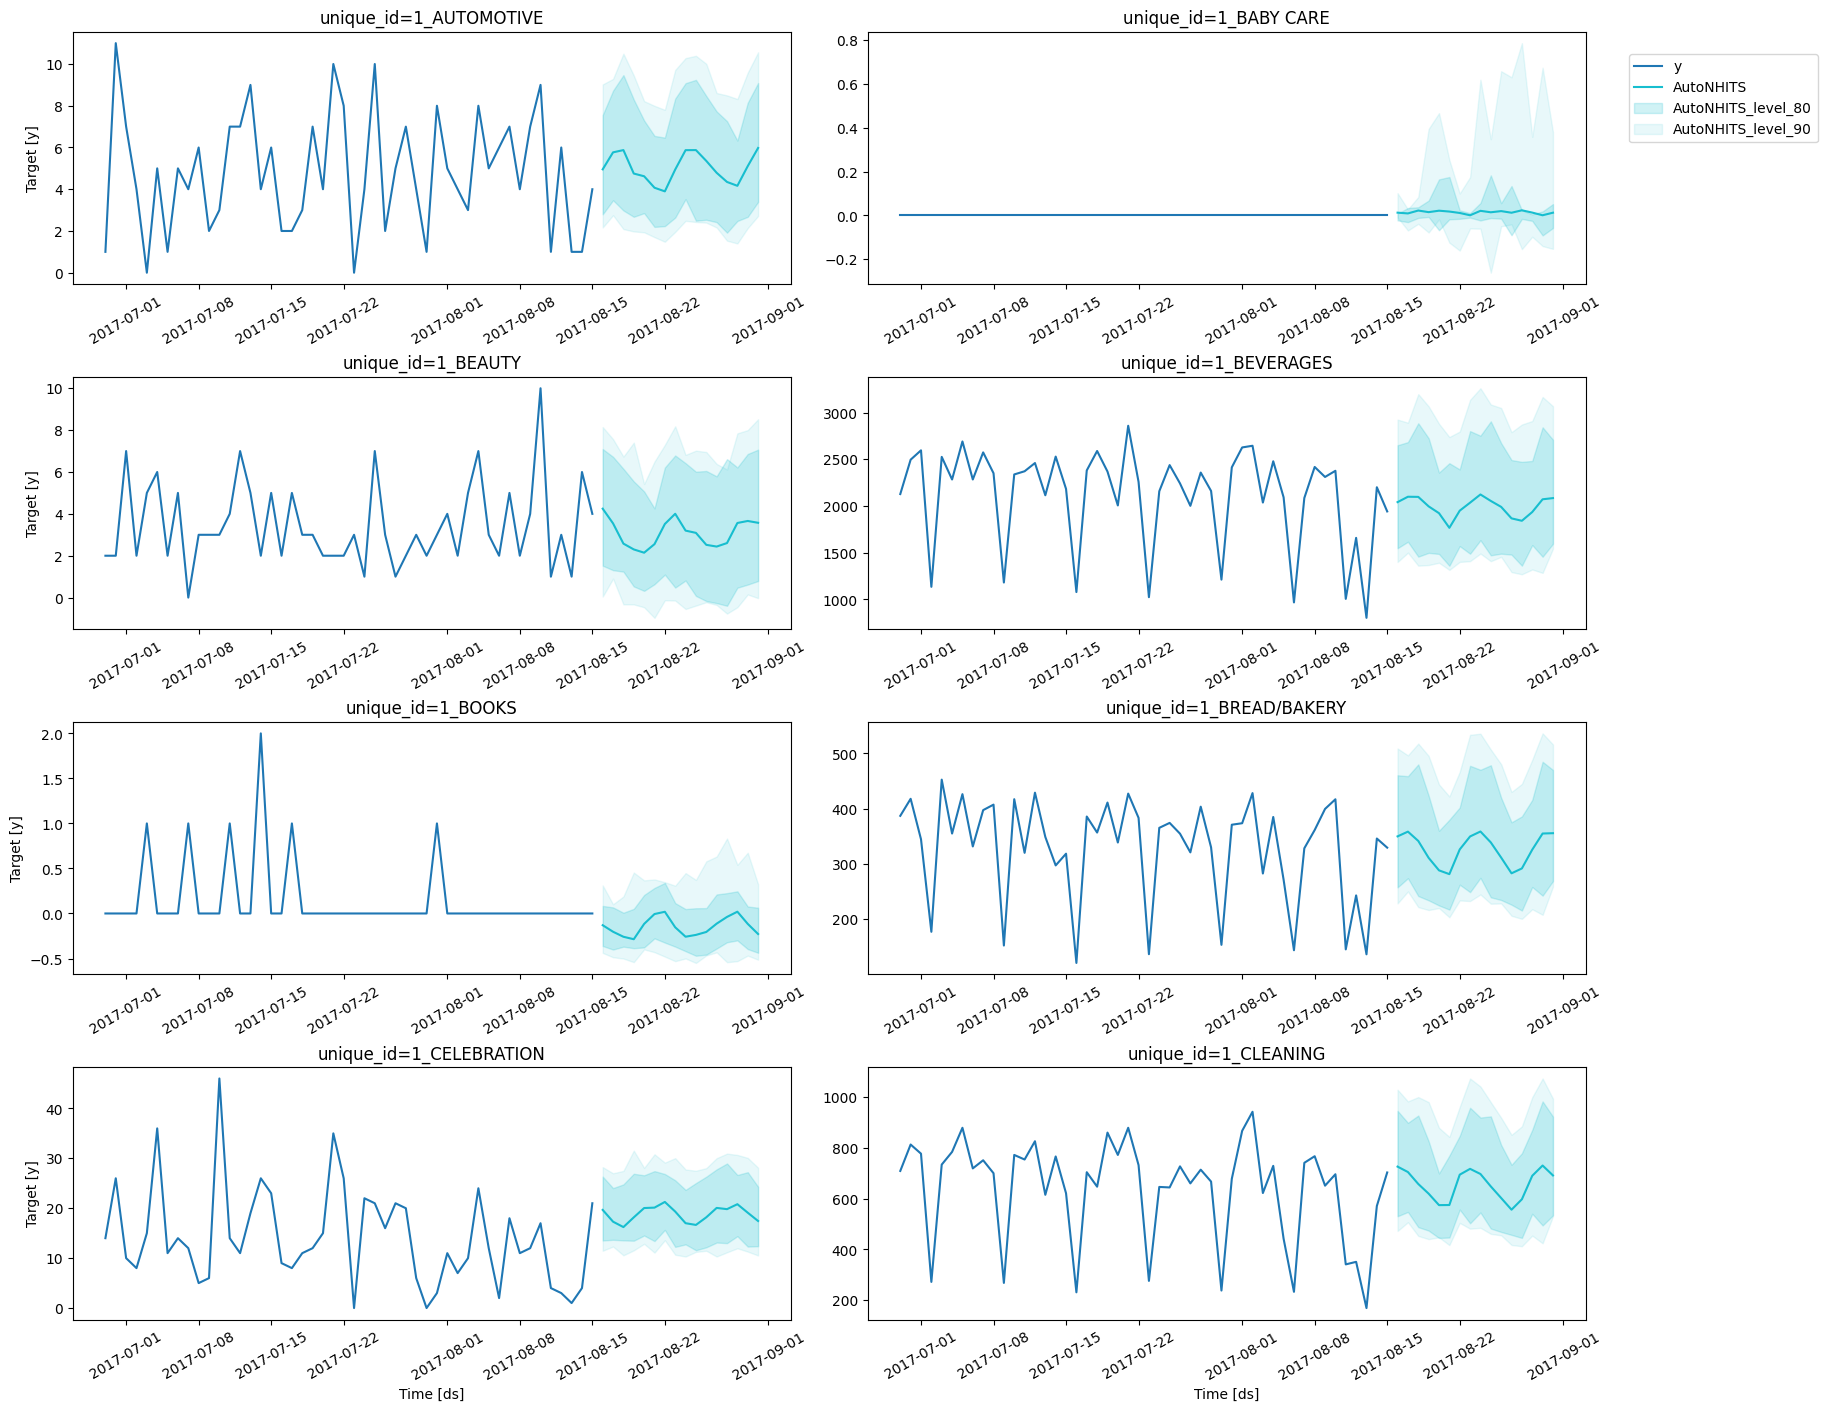

In [833]:
plot_series(df, fcst_df, plot_random=False, max_insample_length=16*3, level=[80, 90])

In [834]:
cv_df = nf.cross_validation(df, n_windows=2)
cv_df.columns = cv_df.columns.str.replace('-median', '')

Epoch 0:  56%|█████▌    | 1000/1782 [02:38<02:03,  6.32it/s, v_num=27, train_loss_step=0.151, valid_loss=125.0, train_loss_epoch=156.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 0:  56%|█████▌    | 1000/1782 [02:38<02:03,  6.32it/s, v_num=27, train_loss_step=0.151, valid_loss=125.0, train_loss_epoch=156.0]


[I 2025-05-18 03:54:29,302] Trial 4 finished with value: 125.35077667236328 and parameters: {'input_size': 96, 'n_pool_kernel_size': (2, 2, 2, 2, 2), 'n_freq_downsample': [8, 4, 2, 1, 1], 'learning_rate': 0.0013131461149145623, 'batch_size': 1, 'windows_batch_size': 512, 'random_seed': 11}. Best is trial 1 with value: 105.3364028930664.
Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 106 K  | train
-------------------------------------------------------
106 K     Trainable params
5         Non-trainable params
106 K     Total params
0.425     Total estimated model params size (

Epoch 5:  59%|█████▊    | 105/179 [00:03<00:02, 31.78it/s, v_num=28, train_loss_step=22.00, train_loss_epoch=103.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 5:  59%|█████▊    | 105/179 [00:03<00:02, 31.73it/s, v_num=28, train_loss_step=22.00, train_loss_epoch=103.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 179/179 [00:01<00:00, 165.40it/s]


In [ ]:
evaluation_df = evaluate(cv_df.drop(columns='cutoff'), metrics=[mse])
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df.head()

,unique_id,metric,AutoNHITS,best_model
0,10_AUTOMOTIVE,mse,3.370560,AutoNHITS
1,10_BABY CARE,mse,0.000272,AutoNHITS
2,10_BEAUTY,mse,3.947149,AutoNHITS
3,10_BEVERAGES,mse,123168.574761,AutoNHITS
4,10_BOOKS,mse,0.000272,AutoNHITS


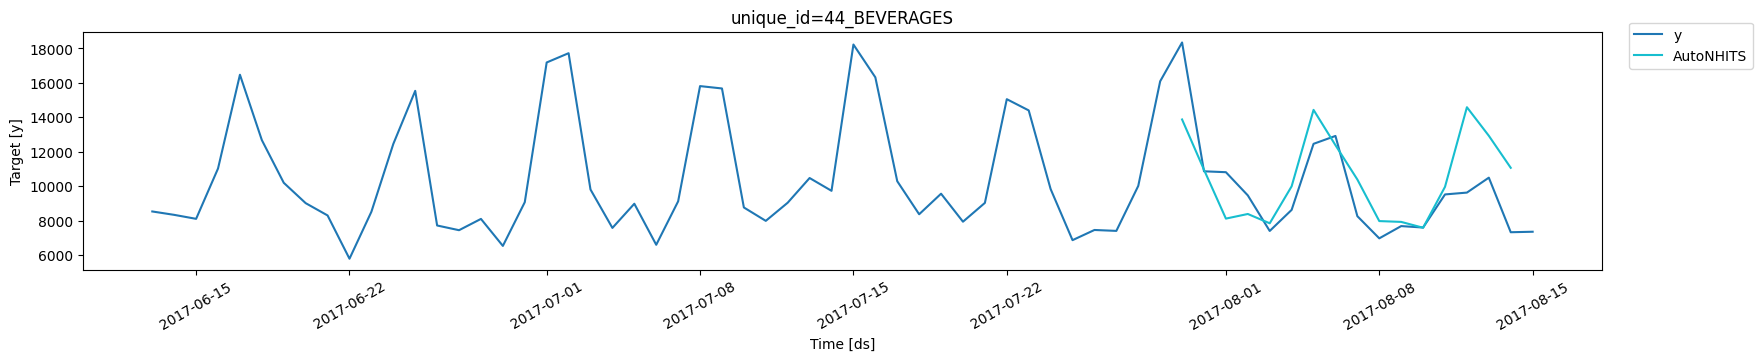

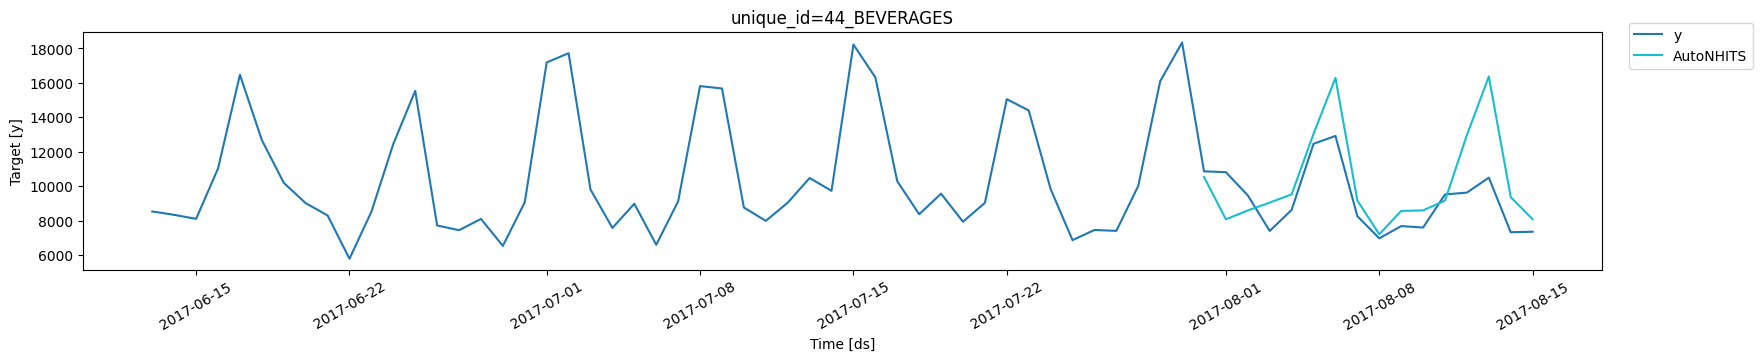

In [839]:
for cutoff in cv_df['cutoff'].unique():
    display(
        plot_series(
            df,
            cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
            max_insample_length=16 * 4,
            ids=['44_BEVERAGES']
        )
    )

In [ ]:
import torch
print(torch.cuda.is_available())       # Should return True
print(torch.cuda.get_device_name(0))   # Prints GPU name


In [ ]:
# # ------------------------------
# # 1. Imports
# # ------------------------------
# import pandas as pd
# import numpy as np
# from neuralforecast import NeuralForecast
# from neuralforecast.models import NHITS
# from sklearn.metrics import mean_squared_log_error
# import optuna

# # ------------------------------
# # 2. Load & Prepare Data
# # ------------------------------
# # Load your data — must contain: 'unique_id', 'ds', 'y', optional covariates
# # For Favorita: unique_id = store_n + '_' + family
# # Ensure datetime and sort

# df = df.rename(columns={'sales': 'y','date':'ds'}).sort_values(['unique_id', 'ds'])

# # Optional log-transform
# df['y'] = np.log1p(df['y'])

# # Keep only necessary columns
# df = df[['unique_id', 'ds', 'y',]]  # Add others as needed

# # ------------------------------
# # 3. Hyperparameter Tuning with Optuna
# # ------------------------------
# horizon = 16

# def objective(trial):
#     model = NeuralForecast(
#         models=[
#             NHITS(
#                 h=horizon,
#                 input_size=trial.suggest_int('input_size', 64, 180),
#                 max_steps=500,
#                 early_stop_patience=2,
#                 learning_rate=trial.suggest_float('lr', 1e-4, 1e-2, log=True),
#                 dropout=trial.suggest_float('dropout', 0.01, 0.2),
#                 n_blocks=trial.suggest_int('n_blocks', 1, 3),
#                 n_layers=trial.suggest_int('n_layers', 1, 3),
#                 futr_exog_list=['onpromotion', 'holiday']
#             )
#         ],
#         freq='D'
#     )

#     # Fit on all data
#     model.fit(df=df)

#     # Predict on horizon
#     fcst = model.predict().reset_index()

#     # Ground truth
#     df_tail = df.groupby('unique_id').tail(horizon).reset_index()
#     merged = df_tail.merge(fcst, on=['unique_id', 'ds'])

#     # # Inverse log transform
#     # y_true = np.expm1(merged['y'])
#     # y_pred = np.expm1(merged['NHITS'])

#     # Compute RMSLE
#     rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
#     return rmsle

# # Run Optuna
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=5)

# # Report results
# print("Best RMSLE:", study.best_value)
# print("Best Parameters:", study.best_trial.params)

# # ------------------------------
# # 4. Final Model with Best Params
# # ------------------------------
# best = study.best_trial.params

# final_model = NeuralForecast(
#     models=[
#         NHITS(
#             h=horizon,
#             input_size=best['input_size'],
#             max_steps=1000,
#             early_stop_patience=3,
#             learning_rate=best['lr'],
#             dropout=best['dropout'],
#             n_blocks=best['n_blocks'],
#             n_layers=best['n_layers'],
#             futr_exog_list=['onpromotion', 'holiday']
#         )
#     ],
#     freq='D'
# )

# # Fit final model
# final_model.fit(df=df)

# # Forecast next 16 days
# forecast = final_model.predict()

# # Inverse log transform for real values
# forecast['yhat'] = np.expm1(forecast['NHITS'])